In [ ]:
"""
Purpose: Implementation fo DiffPool
graph coarsening manner

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
#sys.path.append("/meshAfterParty/meshAfterParty")
sys.path.append("/python_tools/python_tools")
sys.path.append("/machine_learning_tools/machine_learning_tools/")
sys.path.append("/pytorch_tools/pytorch_tools/")
sys.path.append("/neuron_morphology_tools/neuron_morphology_tools/")

from importlib import reload

In [3]:
data_path = Path("./data/m65_full/")
list(data_path.iterdir())

[PosixPath('data/m65_full/cell_type_fine_with_skeleton'),
 PosixPath('data/m65_full/df_morphometrics.pbz2'),
 PosixPath('data/m65_full/cell_type_fine_with_skeleton_no_dense'),
 PosixPath('data/m65_full/cell_type_fine_with_skeleton_directed'),
 PosixPath('data/m65_full/df_cell_type_fine.pbz2')]

In [4]:
#python_tools modules
import system_utils as su
import pandas_utils as pu
import pandas as pd
import numpy as np
import numpy_utils as nu
import networkx_utils as xu
from tqdm_utils import tqdm

#neuron_morphology_tools modules
import neuron_nx_io as nxio

In [5]:
import torch
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import Data
from torch_geometric import transforms

# for the dataset object
from torch_geometric.data import InMemoryDataset, download_url
from torch_geometric.loader import DataLoader
from torch_geometric.data import DenseDataLoader

In [6]:
#pytorch_tools modules
import preprocessing_utils as pret
import geometric_models as gm

# Step 0: Choosing the Model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

with_skeleton = True

features_to_delete = [
    "mesh_volume",
    "apical_label",
    "basal_label",
]

if not with_skeleton:
    features_to_delete +=[
        "skeleton_vector_downstream_phi",      
        "skeleton_vector_downstream_theta",    
        "skeleton_vector_upstream_phi",        
        "skeleton_vector_upstream_theta",  
    ]

features_to_keep = None


device = cpu


# Step 1: Loading the Graph Data

In [8]:
gnn_task = "cell_type_fine"
label_name = None
graph_label = "cell_type_fine_label"
data_file = "df_cell_type_fine.pbz2"
dense_adj = False
directed = False

In [9]:
data_filepath = Path(data_path) / Path(data_file)

data_df = su.decompress_pickle(data_filepath)
data_df

segment_id  split_index  nucleus_id external_layer  \
0      864691134277239760            0       89719        LAYER_6   
1      864691134339067925            0      624899        LAYER_6   
2      864691134366116139            0      476756   WHITE_MATTER   
3      864691134378215335            0        3799      LAYER_2/3   
4      864691134527727930            0      631380   WHITE_MATTER   
...                   ...          ...         ...            ...   
60448  864691137197334593            0      376218        LAYER_6   
60449  864691137197344065            0      191436      LAYER_2/3   
60450  864691137197345345            0      584463      LAYER_2/3   
60451  864691137197353281            0      591241        LAYER_5   
60452  864691137197364801            0      488097      LAYER_2/3   

      external_visual_area                                     cell_type_fine  \
0                       V1  [{'nodelist': ['L0_0'], 'features': ['mesh_vol...   
1                       AL  [{'nodelist': ['L0_1', 'L0_0', 'L0_2'], 'featu...   
2                       RL  [{'nodelist': ['L0_6'], 'features': ['mesh_vol...   
3                       V1  [{'nodelist': ['L0_1', 'L0_0', 'L0_2'], 'featu...   
4                       RL  [{'nodelist': ['L0_0'], 'features': ['mesh_vol...   
...                    ...                                                ...   
60448                   V1  [{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_5',...   
60449                   V1  [{'nodelist': ['L0_0', 'L0_1', 'L0_4', 'L0_6',...   
60450                   RL  [{'nodelist': ['L0_13', 'L4_5', 'L0_8', 'L2_5'...   
60451                   RL  [{'nodelist': ['L4_6', 'L1_10', 'L3_4', 'L0_10...   
60452                   RL  [{'nodelist': ['L0_9', 'L0_8', 'L0_10', 'L0_6'...   

      cell_type_fine_label  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  
...                    ...  
60448                  NaN  
60449                  NaN  
60450                  NaN  
60451                  NaN  
60452                  NaN  

[60453 rows x 7 columns]

In [10]:
"""
Note the cell_type_fine is the column
that has all of the graph data stored
"""

'\nNote the cell_type_fine is the column\nthat has all of the graph data stored\n'

In [11]:
data_df.query("cell_type_fine_label == cell_type_fine_label")

segment_id  split_index  nucleus_id external_layer  \
115    864691134884748026            0      366181        LAYER_5   
147    864691134884761338            0      458241        LAYER_4   
170    864691134884769786            0      592718        LAYER_5   
205    864691134884879610            0      304873        LAYER_5   
213    864691134884945146            0       63499      LAYER_2/3   
...                   ...          ...         ...            ...   
60416  864691137197239105            0      262000        LAYER_4   
60417  864691137197241665            0      308938        LAYER_6   
60433  864691137197306177            0      304611        LAYER_5   
60442  864691137197321281            0      434601        LAYER_5   
60445  864691137197329985            0      260468        LAYER_4   

      external_visual_area                                     cell_type_fine  \
115                     V1  [{'nodelist': ['L0_10', 'L0_11', 'L0_12', 'L0_...   
147                     RL  [{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_3',...   
170                     RL  [{'nodelist': ['L0_18', 'L0_11', 'L0_17', 'L0_...   
205                     V1  [{'nodelist': ['L2_4', 'L1_1', 'L0_3', 'L1_6',...   
213                     V1  [{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_3',...   
...                    ...                                                ...   
60416                   V1  [{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_3',...   
60417                   V1  [{'nodelist': ['L1_4', 'L0_18', 'L4_1', 'L0_16...   
60433                   V1  [{'nodelist': ['L0_1', 'L0_3', 'L0_6', 'L0_0',...   
60442                   RL  [{'nodelist': ['L0_3', 'L3_3', 'L2_2', 'L2_3',...   
60445                   V1  [{'nodelist': ['L0_3', 'L1_79', 'L1_82', 'L0_1...   

      cell_type_fine_label  
115                     4P  
147                    23P  
170                  5P_IT  
205               IT_short  
213                    23P  
...                    ...  
60416                   4P  
60417               Unsure  
60433                5P_NP  
60442                   6P  
60445                  BPC  

[3338 rows x 7 columns]

In [12]:
data_dict = data_df[["cell_type_fine"]].iloc[1].to_list()[0][0]
data_dict

{'nodelist': array(['L0_1', 'L0_0', 'L0_2'], dtype=object),
 'features': array(['mesh_volume', 'n_spines', 'n_synapses_head', 'n_synapses_neck',
        'n_synapses_post', 'n_synapses_pre', 'skeletal_length',
        'total_spine_volume', 'width_upstream', 'width_downstream',
        'apical_label', 'basal_label', 'skeleton_vector_downstream_phi',
        'skeleton_vector_downstream_theta', 'skeleton_vector_upstream_phi',
        'skeleton_vector_upstream_theta', 'width_no_spine'], dtype=object),
 'adjacency': array([[0, 1, 1],
        [1, 0, 0],
        [1, 0, 0]]),
 'feature_matrix': array([[ 3.71170715e-03,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.43345470e+03,  0.00000000e+00,  5.91837642e+01,
          5.91837642e+01,  0.00000000e+00,  1.00000000e+00,
         -6.22637047e-01,  2.00297982e+00, -6.22637047e-01,
          2.00297982e+00,  5.91837642e+01],
        [ 2.99289539e+01,  0.00000000e+00,  0.00000000e+00,
    

# Step 2: Creating the Pytorch Dataset

# -- a) Getting Means and Std Dev for Normalization --

In [13]:
all_batch_df = pd.concat([nxio.feature_df_from_gnn_info(
    k[0],
    return_data_labels_split = False) for k in data_df[gnn_task].to_list()])

if label_name is not None:
    all_batch_df = all_batch_df[[k for k in 
            all_batch_df.columns if k not in nu.convert_to_array_like(label_name)]]
else:
    all_batch_df = all_batch_df
    
# will use these to normalize the data
col_means = all_batch_df.mean(axis=0).to_numpy()
col_stds = all_batch_df.std(axis=0).to_numpy()

all_batch_df_norm = pu.normalize_df(all_batch_df,column_means=col_means,
                                 column_stds = col_stds)
all_batch_df_norm.std()

mesh_volume                         1.0
n_spines                            1.0
n_synapses_head                     1.0
n_synapses_neck                     1.0
n_synapses_post                     1.0
n_synapses_pre                      1.0
skeletal_length                     1.0
total_spine_volume                  1.0
width_upstream                      1.0
width_downstream                    1.0
apical_label                        1.0
basal_label                         1.0
skeleton_vector_downstream_phi      1.0
skeleton_vector_downstream_theta    1.0
skeleton_vector_upstream_phi        1.0
skeleton_vector_upstream_theta      1.0
width_no_spine                      1.0
dtype: float64

# --- b) Creating the Dataset Class --

In [14]:
# -- mapping of the labels to integers --
total_labels,label_counts = np.unique((data_df.query(f"{graph_label}=={graph_label}")[
    graph_label]).to_numpy(),return_counts = True)
cell_type_map = {k:i+1 for i,k in enumerate(total_labels)}
cell_type_map[None] = 0
cell_type_map

{'1P': 1,
 '23P': 2,
 '4P': 3,
 '5P_IT': 4,
 '5P_NP': 5,
 '5P_PT': 6,
 '6CT': 7,
 '6P': 8,
 '6P_CT': 9,
 '6P_IT': 10,
 '6P_U': 11,
 'BC': 12,
 'BPC': 13,
 'I targeting non_bpc': 14,
 'IT_big_tuft': 15,
 'IT_short': 16,
 'IT_small_tuft': 17,
 'Martinotti': 18,
 'NGC': 19,
 'Pvalb': 20,
 'SST': 21,
 'Unsure': 22,
 'VIP': 23,
 'WM_P': 24,
 'cb1 basket': 25,
 'chandelier': 26,
 'l1vip': 27,
 'ndnf+npy_': 28,
 'ngfc': 29,
 'prox targeting': 30,
 'small basket': 31,
 None: 0}

In [15]:
#cell_type_map
cell_type_fine_classifier_weights = {
'23P': 0.25,#1294
'4P': 0.3,#890
'5P_IT': 0.5,#465
'6P': 0.8,#342
'6P_IT': 0.8,#263
'5P_PT': 0.8,#224
}


class_idx = np.array(list(cell_type_map.values()) )
class_labels = np.array(list(cell_type_map.keys()) )
weights = np.array([cell_type_fine_classifier_weights.get(k,1) for k in class_labels])
weights = weights[np.argsort(class_idx)]
weights

array([1.  , 1.  , 0.25, 0.3 , 0.5 , 1.  , 0.8 , 1.  , 0.8 , 1.  , 0.8 ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

In [16]:
def pytorch_data_from_gnn_info(
    gnn_info,
    y = None,
    verbose = False,
    normalize = True,
    features_to_delete=None,
    features_to_keep = None
    ): 
    """
    Purpose: To convert our data format into pytorch Data object

    Pseudocode: 
    1) Create the edgelist (turn into tensor)
    2) Get the 
    """
    edgelist = torch.tensor(xu.edgelist_from_adjacency_matrix(
        array = gnn_info["adjacency"],
        verbose = False,
    ).T,dtype=torch.long)

    x,y_raw = nxio.feature_df_from_gnn_info(
        gnn_info,
        return_data_labels_split = True)
    if y is None:
        y = y_raw
        
    if not type(y) == str:
        y = None
        
    y_int = np.array(cell_type_map[y] ).reshape(1,-1)
    
    if normalize:
        x = (x-col_means)/col_stds
    
    # --- keeping or not keeping sertain features
    gnn_features = gnn_info["features"]

    keep_idx = np.arange(len(gnn_features))
    if features_to_delete is not None:
        curr_idx = np.array([i for i,k in enumerate(gnn_features)
                       if k not in features_to_delete])
        keep_idx = np.intersect1d(keep_idx,curr_idx)
        if verbose:
            print(f"keep_idx AFTER DELETE= {keep_idx}")
    if features_to_keep is not None:
        curr_idx = np.array([i for i,k in enumerate(gnn_features)
                       if k in features_to_keep])
        keep_idx = np.intersect1d(keep_idx,curr_idx)
        if verbose:
            print(f"keep_idx AFTER KEEP = {keep_idx}")

    x = x[:,keep_idx]

    x = torch.tensor(x,dtype=torch.float)
    y = torch.tensor(y_int,dtype=torch.long)
    
    if len(y) > 1:
        raise Exception(f"y = {y}")
        
    if y.shape[0] != 1 or y.shape[1] != 1:
        raise Exception(f"y = {y}")


    if verbose:
        print(f"x.shape = {x.shape},y.shape ={y.shape}")

    data = Data(x=x,y=y,edge_index=edgelist)
    return data

In [17]:
class CellTypeDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        #return ['some_file_1', 'some_file_2', ...]
        return [str(data_filepath.absolute())]

    @property
    def processed_file_names(self):
        return ['data.pt']

    # def download(self):
    #     # Download to `self.raw_dir`.
    #     download_url(url, self.raw_dir)
    #     ...

    def process(self):
        # Read data into huge `Data` list.
        #data_list = [...]

#         if data_df is None:
#             data_df = su.decompress_pickle(self.raw_file_names[0])

        
        
        data_list = []
        for k,y in tqdm(zip(
            data_df[gnn_task].to_list(),
            data_df[graph_label].to_list())):
            
            data_list.append(pytorch_data_from_gnn_info(
                k[0],
                y=y,
                features_to_delete=features_to_delete,
                features_to_keep = features_to_keep,
                verbose = False))

        if self.pre_filter is not None:
            data_list_final = []
            for data in data_list:
                try:
                    if self.pre_filter(data):
                        data_list_final.append(data)
                except:
                    continue
                    
            data_list = data_list_final
            
        for j,d in enumerate(data_list):
            if d.y.shape[0] != 1 or d.y.shape[1] != 1:
                raise Exception(f"{j}")

        if self.pre_transform is not None:
            data_list_final = []
            for j,data in enumerate(data_list):
                try:
                    curr_t = self.pre_transform(data)
                    if curr_t.y.shape[0] != 1 or curr_t.y.shape[1] != 1:
                        raise Exception(f"{j}, data = {curr_t}")
                    data_list_final.append(curr_t)
                except:
                    continue
            data_list = data_list_final
            
        for j,d in enumerate(data_list):
            if d.y.shape[0] != 1 or d.y.shape[1] != 1:
                raise Exception(f"{j}, data = {d}")

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [18]:
if with_skeleton:
    gnn_task_name = f"{gnn_task}_with_skeleton"
else:
    gnn_task_name = f"{gnn_task}"

if dense_adj:
    processed_data_folder = data_path / Path(f"{gnn_task_name}")#_processed_dense")
elif directed:
    processed_data_folder = data_path / Path(f"{gnn_task_name}_directed")#_processed_dense")
else:
    processed_data_folder = data_path / Path(f"{gnn_task_name}_no_dense")#_processed_dense")
    
# try:
#     su.rm_dir(processed_data_folder)
# except:
#     pass

processed_data_folder.mkdir(exist_ok = True)

In [19]:
max_nodes = np.max(all_batch_df_norm.index.to_numpy()) + 1

class MyFilter(object):
    def __call__(self, data):
        return data.num_nodes <= max_nodes
    
if dense_adj:
    #gets the maximum number of nodes in any of the graphs
    transform_list = [
        transforms.ToUndirected(),
        T.ToDense(max_nodes),
        #transforms.NormalizeFeatures(),
    ]
    pre_filter = MyFilter()
elif directed:
    transform_list = []
    pre_filter = None
else:
    transform_list = [
        transforms.ToUndirected(),
    ]
    
    pre_filter = None
    

transform_norm = transforms.Compose(transform_list)
dataset = CellTypeDataset(
        processed_data_folder.absolute(),
        pre_transform = transform_norm,
        pre_filter = pre_filter,
        )

In [20]:
for j,d in enumerate(dataset):
    if d.y.shape[0] != 1 or d.y.shape[1] != 1:
        raise Exception(f"{j}")

In [21]:
dataset_num_node_features = dataset.num_node_features
dataset_num_classes = dataset.num_classes

In [22]:
# looking at the dataset
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset_num_node_features}')
print(f'Number of classes: {dataset_num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Has isolated nodes: {data.has_isolated_nodes()}')
# print(f'Has self-loops: {data.has_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')


Dataset: CellTypeDataset(58948):
Number of graphs: 58948
Number of features: 14
Number of classes: 32

Data(x=[3, 14], edge_index=[2, 4], y=[1, 1])
Number of nodes: 3
Number of edges: 4
Average node degree: 1.33


# --- c) Splitting the Data into Labeled and unlabeled

In [23]:
labeled_mask = np.array(
    [True if k.y[0][0] > 0 else False for k in dataset]
).astype('int')
dataset_labeled = dataset[np.where(labeled_mask)[0]]
len(dataset_labeled)

3338

In [24]:
dataset_curr = dataset_labeled
torch.manual_seed(12345)
dataset_curr = dataset_curr.shuffle()

# --- d) Split Train/Validation/Test

In [25]:
"""
Purpose: To turn percentages into raw lengths

"""

'\nPurpose: To turn percentages into raw lengths\n\n'

In [26]:
batch_size = 64

(train_dataset,
val_dataset,
test_dataset,) = pret.train_val_test_split(
    dataset_curr,
    return_dict=False,
    verbose = True)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(f'Number of val graphs: {len(val_dataset)}')

test size = 667.0 (0.2 %)
validation size = 667.0 (0.2 %)
train_size = 2004.0
data_lengths_with_train = [2004  667  667]
Number of training graphs: 2004
Number of test graphs: 667
Number of val graphs: 667


In [27]:
# # if wanted to try and add weights
# y_train = np.array([int(data.y[0][0].numpy()) for data in train_dataset])
# y_train_classes,y_train_count = np.unique(y_train,return_counts = True)
# y_train_classes,y_train_count

# sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

# weight = {i:1/}
# samples_weight = np.array([weight[t] for t in y_train])
# samples_weight = torch.from_numpy(samples_weight)
# samples_weight

In [28]:
if dense_adj:
    data_loader_mod = DenseDataLoader
else:
    data_loader_mod = DataLoader


train_loader = data_loader_mod(train_dataset, batch_size=batch_size,shuffle = True)
test_loader = data_loader_mod(test_dataset, batch_size=batch_size,shuffle=False)
val_loader = data_loader_mod(val_dataset, batch_size=batch_size,shuffle=False)

# Step 3a; Picking the Model

In [29]:
model_name = "GCNFlat"
n_epochs = 300


import general_utils as gu
architecture_kwargs_global = dict(
    n_hidden_channels = 32, 
    #n_hidden_channels=64, 
    #first_heads=8, 
    #output_heads=1, 
    #dropout=0.6,
    global_pool_type="mean",
    n_layers = 2
)

optimizer_kwargs_global = dict(
    lr=0.01
)

all_run_kwargs = [
#      dict(architecture_kwargs = {'n_hidden_channels': 32, 'global_pool_type': 'mean', 'n_layers': 2,
#                                 # "use_bn":False, "n_hidden_layers_classifier": 0
#                                 }),
          dict(architecture_kwargs = {'n_hidden_channels': 128, 'global_pool_type': 'mean', 'n_layers': 2,}),
        dict(architecture_kwargs = {'n_hidden_channels': 8, 'global_pool_type': 'mean', 'n_layers': 2,}),
    
    dict(architecture_kwargs = {'n_hidden_channels': 64, 'global_pool_type': 'mean', 'n_layers': 3,
                                # "use_bn":False, "n_hidden_layers_classifier": 0
                                }),
          dict(architecture_kwargs = {'n_hidden_channels': 128, 'global_pool_type': 'mean', 'n_layers': 3,}),
        dict(architecture_kwargs = {'n_hidden_channels': 8, 'global_pool_type': 'mean', 'n_layers': 3,}),
#     dict(architecture_kwargs = dict(n_hidden_channels = 64),),
#     dict(architecture_kwargs = dict(n_hidden_channels = 128),),
#     dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 64),),
#     dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 128),),
    
    
#     dict(architecture_kwargs = dict(n_hidden_channels = 32,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_hidden_channels = 16,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_hidden_channels = 8,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 32,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 16,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 8,global_pool_type="add"),),

]

# Step 3: Training the Model

In [30]:
import evaluation_utils as evu
import torch.nn.functional as F
import model_utils as mdlu
verbose = True

In [31]:
for j,config_dict in enumerate(all_run_kwargs):
    
    architecture_kwargs = config_dict.get("architecture_kwargs",dict())
    optimizer_kwargs = config_dict.get("optimizer_kwargs",dict())
    
    architecture_kwargs = gu.merge_dicts([architecture_kwargs_global.copy(),architecture_kwargs])
    optimizer_kwargs = gu.merge_dicts([optimizer_kwargs_global.copy(),optimizer_kwargs])
    
    run_kwargs = gu.merge_dicts([architecture_kwargs,optimizer_kwargs])

    
    if verbose:
        print(f"\n\n\n****------ Running Model Config {j} with following parameters ------****\n{run_kwargs}")

    model = getattr(gm,model_name)(
        dataset_num_node_features=dataset_num_node_features,
        dataset_num_classes=dataset_num_classes,
        **architecture_kwargs
        )

    optimizer = torch.optim.Adam(model.parameters(), **optimizer_kwargs)
    print(model)


    
    # ---------------- Configuring the Tensorboard and Checkpoinns--------------------
    from torch.utils.tensorboard import SummaryWriter

    tensorboard_dir = Path("./tensorboard")
    tensorboard_dir.mkdir(exist_ok=True)
    tensorboard_dir = tensorboard_dir / Path(f"{model_name}")
    tensorboard_dir.mkdir(exist_ok=True)

    tensorboard_file_name = (f'{model_name}_' 
                             + "_".join([f"{k}_{v}" for k,v in run_kwargs.items()]))
    tensorboard_file_name += f"_with_skeleton_{with_skeleton}"
    print(f"tensorboard_file_name = {tensorboard_file_name}")
    tensorboard_file = tensorboard_dir / Path(f'{tensorboard_file_name}')
    try:
        su.rm_dir(tensorboard_file)
    except:
        pass
    tensorboard_file.mkdir(exist_ok = True)


    #-- when to save a checkpoint of the model
    checkpoint_dir = Path("./model_checkpoints")
    checkpoint_dir.mkdir(exist_ok = True)
    checkpoint_dir = checkpoint_dir / Path(f"{model_name}")
    checkpoint_dir.mkdir(exist_ok = True)
    checkpoint_path = checkpoint_dir / Path(f"./{tensorboard_file_name}_checkpoints")

    try:
        su.rm_dir(checkpoint_path)
    except:
        pass

    checkpoint_path.mkdir(exist_ok = True)
    n_epoch_for_checkpoint = 5

    writer = SummaryWriter(tensorboard_file)
    

    print(model)


    # weights = weight#[0.1,0.5,,1,0.7,1,1,1]
    # class_weights = None
    class_weights = torch.FloatTensor(weights).to(device)

    tensor_map = None

    def train():
        model.train()

        for data in train_loader:#train_loader:  # Iterate in batches over the training dataset.
            #print(f"data = {data}")
            data = data.to(device)
            if model_name == "DiffPool":
                out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
                #y_true = data.y.reshape(-1,3)
            elif model_name == "TreeLSTM":
                n = data.x.shape[0]
                h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
                c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
                out = model(
                    data,
                    h = h,
                    c = c,
                    embeddings = data.x
                    )
            else:
                out = model(data)
            y_true = data.y.squeeze_()
            #print(f"out.shape = {out.shape}, data.y.shape = {data.y.shape}")
            loss = F.nll_loss(
                torch.log(out), y_true,
                weight = class_weights,
            )  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
            return loss


    def test(loader,verbose = False):
        model.eval()
        y_pred_list = []
        y_true_list = []
        for data in loader:  # Iterate in batches over the training/test dataset.
            data = data.to(device)
            if model_name == "DiffPool":
                out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
                #y_true = data.y.reshape(-1,3)
            elif model_name == "TreeLSTM":
                n = data.x.shape[0]
                h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
                c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
                out = model(
                    data,
                    h = h,
                    c = c,
                    embeddings = data.x
                    )
            else:
                out = model(data)

            y_pred = out.argmax(dim=1)  # Use the class with highest probability.
            y_true = data.y.squeeze_()
            y_pred_list.append(y_pred)
            y_true_list.append(y_true)
    #         error_idx = np.where(pred > 0)[0]
    #         if len(error_idx) > 0:
    #             print(f"error_idx = {error_idx}")
        y_pred = torch.cat(y_pred_list)
        y_true = torch.cat(y_true_list)

        return evu.metric_dict(
            y_true,
            y_pred,
            tensor_map=tensor_map,
            metrics=["accuracy"],
        )

    log_to_tensorboard = True
    for epoch in range(0, n_epochs):
        loss = train()
        writer.add_scalar('loss',loss,epoch) # new line
        train_metric_dict = test(train_loader)#train_loader)
        val_metric_dict = test(val_loader)#test_loader)

        if epoch % n_epoch_for_checkpoint == 0 and epoch != 0:
            val_acc = val_metric_dict['accuracy'].numpy()
            checkpoitn_filepath = checkpoint_path / Path(f"{tensorboard_file_name}_epoch_{epoch}")#_val_acc_{val_acc:.2f}")
            print(f"Saving off checkpoint {checkpoitn_filepath}")
            mdlu.save_checkpoint(model,filepath = checkpoitn_filepath,epoch = epoch,loss = loss)


        print(f'Epoch: {epoch:03d}, loss = {loss}')
        for type_name,metric_dict in zip(["train","val"],[train_metric_dict,val_metric_dict]):
            print_log = f"   {type_name} metrics: "
            for k,v in metric_dict.items():
                if log_to_tensorboard:
                    writer.add_scalar(f'{type_name}_{k}',v,epoch)
                print_log += f" {k}: {v:4f},"

            print(print_log)




****------ Running Model Config 0 with following parameters ------****
{'n_hidden_channels': 128, 'global_pool_type': 'mean', 'n_layers': 2, 'lr': 0.01}
GCNFlat(
  (conv0): GCNConv(14, 128)
  (conv1): GCNConv(128, 128)
  (lin): Linear(in_features=128, out_features=32, bias=True)
)
tensorboard_file_name = GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True
GCNFlat(
  (conv0): GCNConv(14, 128)
  (conv1): GCNConv(128, 128)
  (lin): Linear(in_features=128, out_features=32, bias=True)
)
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3 10 12 13 18],y_pred_counts = [   2   69 1746   56   40   91]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  6  8 12 13 18],y_pred_counts = [1367    4   32  270  160   15  156]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  6  8 12 13 18],y_pred_counts = [448   4  14  79  71   5  46]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_epoch_10
Epoch: 010, loss = 2.186807870864868
   train metrics:  accuracy: 0.360778,
   val metrics:  accur

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 12 18],y_pred_counts = [894  94 573  65  58 150  97  73]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 12 18],y_pred_counts = [306  30 179  22  23  43  41  23]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_epoch_20
Epoch: 020, loss = 1.8604062795639038
   train metrics:  accuracy: 0.441617,
   val metrics

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  5  6  8 10 12 13 18],y_pred_counts = [769 286  51 138 152 410  63 120  15]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [271  90   1  20  59  46 108  24  42   6]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_epoch_30
Epoch: 030, loss = 1.5530215501785278
   train metrics:  accuracy: 0.4

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  9 10 12 14 18 21 29],y_pred_counts = [  1 447 673 227  50  99  89 257  97   6  53   4   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 14 18 21 29],y_pred_counts = [161 221  88  15  33   1  25  64  41   1  14   2   1]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_epoch_40
Epoch: 040, loss = 1.

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [479 667 132  53 106 173   8 181  77   1 127]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 18],y_pred_counts = [174 217  48  17  38  51   1  45  28  48]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_epoch_50
Epoch: 050, loss = 1.6582857370376587
   train metrics: 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [585 495 312  48  94  42   9 251  95  51  22]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [213 158 108  11  36  14   1  64  38  16   8]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_epoch_60
Epoch: 060, loss = 1.7137446403503418
   train me

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [246  78  66  14  41 119  25  18  23  37]
Epoch: 069, loss = 1.7224948406219482
   train metrics:  accuracy: 0.511477,
   val metrics:  accuracy: 0.535232,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 22],y_pred_counts = [758 227 176  51  89 432  73  46  40 111   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [453 687  59  54  64 347   1 150  81  46  59   2   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [163 230  21  17  25 105  38  28  22  18]
Epoch: 079, loss = 1.7614903450012207
   train metrics:  accuracy: 0.542415,
   val metrics:  accuracy: 0.563718,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 14 18 19],y_pred_counts = [242 126  75  11  35  11  11  89  25  25   1  15   1]
Epoch: 088, loss = 1.625394582748413
   train metrics:  accuracy: 0.551896,
   val metrics:  accuracy: 0.583208,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 14 18 19 22],y_pred_counts = [693 400 150  48  80  39  39 370  59  61   1  57   5   2]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  3

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 18 22],y_pred_counts = [514 535  56  44  87 414  39  90  54  43   1 114  13]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22],y_pred_counts = [195 165  16   9  31 133   7  25  24  17  41   4]
Epoch: 098, loss = 1.3643909692764282
   train metrics:  accuracy: 0.549900,
   val metrics:  accuracy: 0.557721,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [ 54 255 159  11  36  31  10  45  30  16  20]
Epoch: 107, loss = 1.5571085214614868
   train metrics:  accuracy: 0.498004,
   val metrics:  accuracy: 0.466267,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [187 762 420  53  86  98  72 145  77  17  87]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22 29],y_pred_counts = [461 506  50  56  81 490   4 162  86  44  55   5   4]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 22 24 29],y_pred_counts = [160 166  13  18  34 156  47  32  18  19   2   1   1]
Epoch: 117, loss = 1.742365837097168
   train metrics:  accuracy: 0.531437,
   val metrics:  accuracy: 0.532234,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 14 16 18 21 22 29],y_pred_counts = [631 439 192  44 101 269   1 144  63  41   1   2  55  10   2   9]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 14 18 21 22 29],y_pred_counts = [220 149  62   9  41  81  38  25  19   1  19   1   1   1]
Epoch: 126, loss = 1.4630810022354126
   train metrics:  accuracy: 0.577844,
   val metrics:  accuracy: 0.584708,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [239 139  81  18  38  37  18  28  22  32  15]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_epoch_135
Epoch: 135, loss = 1.3124860525131226
   train metrics:  accuracy: 0.560379,
   val metrics:  accuracy: 0.583208,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22 24],y_pred_counts = [604 400 306  47  66 223   3 161  76  14  68  31   2   3]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 14 18 21 24],y_pred_counts = [218 121 110  10  23  65   1  48  27   5   1  25  11   2]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_epoch_145
Epoch:

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 13 15 18 21 22 24 29],y_pred_counts = [490 462 239  45 111   1 279   1 177  55  30   2  75   3   2  11  21]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 22 24 29],y_pred_counts = [177 147  86   9  46  77  56  23  12  25   1   3   5]
Epoch: 154, loss = 1.5997319221496582
   train metrics:  accuracy: 0.561377,
   val metrics:  accuracy: 0.560720,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 13 17 18 21 22 24 29],y_pred_counts = [742 311  62  76  83   4 166 128 102  75  47 131  52   5  17   2   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 17 18 22 24],y_pred_counts = [243 111  25  23  35  57  34  27  27  19  37  22   5   2]
Epoch: 163, loss = 1.1961405277252197
   train metrics:  accuracy: 0.547405,
   val metrics:  accuracy: 0.544228,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_cou

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 21 22],y_pred_counts = [549 552  98  45  85 428  61  43  67  53  17   6]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 14 17 18 21 22],y_pred_counts = [209 176  36   9  35 118  17  17  21   1   1  19   7   1]
Epoch: 172, loss = 1.496708631515503
   train metrics:  accuracy: 0.579840,
   val metrics:  accuracy: 0.565217,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 1

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 11 12 13 15 18 22 29],y_pred_counts = [296  85  88  10  35  13  26  43   1  26  33   1   7   2   1]
Epoch: 181, loss = 1.346320390701294
   train metrics:  accuracy: 0.567864,
   val metrics:  accuracy: 0.574213,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 11 12 13 15 18 21 22 29],y_pred_counts = [760 358 235  48  85 109 116  97   2  81  83   3  19   1   2   5]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 20

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 19 21 22 29],y_pred_counts = [875  69 242  49 100 225  16 244  50  30  85   1  14   2   2]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 29],y_pred_counts = [288  30  85  13  36  67   4  76  21  15  25   6   1]
Epoch: 191, loss = 1.7777923345565796
   train metrics:  accuracy: 0.520459,
   val metrics:  accuracy: 0.541229,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 22

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 16 17 18 22 24],y_pred_counts = [ 55 312  34  15  38  12  22  91  30  25   1   4   2  20   3   3]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_epoch_200
Epoch: 200, loss = 1.3889143466949463
   train metrics:  accuracy: 0.498004,
   val metrics:  accuracy: 0.457271,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_uniq

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 14 18 19 22 23 24 29],y_pred_counts = [254 118  71  17  27  67  10  37  30  10   1  16   1   1   2   2   3]
Epoch: 209, loss = 1.317667007446289
   train metrics:  accuracy: 0.601796,
   val metrics:  accuracy: 0.599700,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 13 14 15 18 19 22 23 24 27 29],y_pred_counts = [451 588 240  62  65   3 168  36 194  78  26   6   3  55   1   8   3   7
   2   8]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 17 18 21 22 24 29],y_pred_counts = [859 251 217  49  82  77 120 133  39  66   1  15  87   1   2   2   3]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 17 18 22 29],y_pred_counts = [294  91  61  15  34  17  31  41  14  26   5  36   1   1]
Epoch: 218, loss = 1.4811335802078247
   train metrics:  accuracy: 0.573353,
   val metrics:  accuracy: 0.559220,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_cou

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 13 17 18 21 22],y_pred_counts = [470 518 341  44 111   4 117  99 109  45  59   6  72   7   2]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 17 18 21],y_pred_counts = [162 170 115   9  43  33  27  35  18  21   4  27   3]
Epoch: 227, loss = 1.4090310335159302
   train metrics:  accuracy: 0.599301,
   val metrics:  accuracy: 0.583208,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 22

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 13 15 17 18 21 22 29],y_pred_counts = [452 542 157  59  85   7 121  90 294  62  82   1   7  27   7   1  10]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 13 15 17 18 21 29],y_pred_counts = [157 175  55  18  37   1  29  26  98  24  32   1   2   7   3   2]
Epoch: 236, loss = 1.426008939743042
   train metrics:  accuracy: 0.576846,
   val metrics:  accuracy: 0.560720,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 3

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 13 15 17 18 21 22 24 29],y_pred_counts = [738 245 186  55  91   1 264  49 147  63  43   4   3  68   3  10  26   8]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 17 18 21 22 24 29],y_pred_counts = [253  77  62  19  40  83  10  40  23  17   2   1  25   3   2   8   2]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_lay

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 11 12 13 15 17 18 22 23 29],y_pred_counts = [740 309 285  44  76 113 105 140   3  38  82   2   6  53   2   1   5]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 11 12 13 16 17 18 21 29],y_pred_counts = [256 106 104   9  28  27  26  40   1  14  29   1   3  20   1   2]
Epoch: 254, loss = 1.156529188156128
   train metrics:  accuracy: 0.598802,
   val metrics:  accuracy: 0.581709,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 3

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 11 12 13 15 17 18 21 22 23 24 29],y_pred_counts = [553 438 271  47  81 225  15 144   9  44  34   2  21 100  10   1   1   6
   2]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 11 12 13 15 17 18 21 23 24 29],y_pred_counts = [199 130 106  14  33  58   5  40   3  14  14   1   5  36   3   1   4   1]
Epoch: 263, loss = 1.2951545715332031
   train metrics:  accuracy: 0.610778,
   val metrics:  accuracy: 0.575712,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 17 18 21 22 23 24 27 29],y_pred_counts = [269  96  40  14  38  20  36  65  23  18   1   6   6   9   6   9   7   1
   3]
Epoch: 271, loss = 1.6733670234680176
   train metrics:  accuracy: 0.561876,
   val metrics:  accuracy: 0.568216,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 17 18 21 22 23 24 27 29],y_pred_counts = [734 322  96  46  84  55 182 221  48  81   3  33  20  16  22  14  16   1
  10]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 14 17 18 23 24 27 29],y_pred_counts = [180 153 120  18  30  55   7   8  14  23   1  25  19   1   3   1   9]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_epoch_280
Epoch: 280, loss = 1.451149344444275
   train metrics:  accuracy: 0.585828,
   val metrics:  accuracy: 0.563718,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pre

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 11 12 13 14 15 16 18 19 21 22 24 29],y_pred_counts = [646 395 172  46  99 252  44 120   4  53  20   9   9   9  78   1  27  15
   3   2]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 11 12 13 14 15 16 18 21 22 24 29],y_pred_counts = [235 124  59  11  44  69  10  34   1  24  11   2   2   2  24   7   5   2
   1]
Epoch: 289, loss = 1.3316181898117065
   train metrics:  accuracy: 0.599800,
   val metrics:  accuracy: 0.587706,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 14 16 18 19 20 21 22 24 28],y_pred_counts = [576 385 288  44  79  98 100 237  56  48  13   7  60   4   1   1   3   2
   2]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 14 16 18 19 21 22 24],y_pred_counts = [198 125 111  10  33  30  18  68  24  20   3   3  19   1   1   1   2]
Epoch: 298, loss = 1.3395346403121948
   train metrics:  accuracy: 0.603293,
   val metrics:  accuracy: 0.599700,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [3 8 9],y_pred_counts = [1335  239  430]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [3 8 9],y_pred_counts = [416  86 165]
Epoch: 008, loss = 3.0988810062408447
   train metrics:  accuracy: 0.241517,
   val metrics:  accuracy: 0.194903,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [3 8 9],y_pred_counts = [1529  

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [3 8],y_pred_counts = [408 259]
Epoch: 019, loss = 3.0138556957244873
   train metrics:  accuracy: 0.253493,
   val metrics:  accuracy: 0.221889,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [3 8],y_pred_counts = [1212  792]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [3 8],y_pred_counts = [386 281]
Saving off checkpoint model_checkpoints/

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [2 3 8],y_pred_counts = [247 154 266]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_8_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_8_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_epoch_30
Epoch: 030, loss = 2.579871654510498
   train metrics:  accuracy: 0.347804,
   val metrics:  accuracy: 0.335832,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  6  8 10],y_pred_counts = [718 594   2   1 677  12]
   y_true_unique= [ 1  2  3  4  5 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  6  8 10],y_pred_counts = [ 341 1080   17  550   16]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  6  8 10],y_pred_counts = [115 352   5 191   4]
Epoch: 041, loss = 2.5567541122436523
   train metrics:  accuracy: 0.361277,
   val metrics:  accuracy: 0.358321,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_uni

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  6  8 10],y_pred_counts = [ 78 416  24 146   3]
Epoch: 051, loss = 2.6805543899536133
   train metrics:  accuracy: 0.347804,
   val metrics:  accuracy: 0.343328,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  5  6  8 10],y_pred_counts = [ 223 1269    1   74  429    8]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  6  8 10

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  5  6  8 10],y_pred_counts = [512 989  29  59 382  33]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  5  6  8 10],y_pred_counts = [191 313   6  21 122  14]
Epoch: 062, loss = 2.298881769180298
   train metrics:  accuracy: 0.407685,
   val metrics:  accuracy: 0.409295,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  5  6  8 10],y_pred_counts = [214 175  24  38 185  31]
Epoch: 072, loss = 2.4488067626953125
   train metrics:  accuracy: 0.394212,
   val metrics:  accuracy: 0.397301,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10],y_pred_counts = [623 575   2  67 115 537  85]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13],y_pred_counts = [345 823  31 115 159 466  61   2   2]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10],y_pred_counts = [121 263   7  39  60 164  13]
Epoch: 083, loss = 2.422792673110962
   train metrics:  accuracy: 0.401697,
   val metrics:  accuracy: 0.391304,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [ 112 1021    2  113   68  625   29   19   14    1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  5  6  8 10 12 13 18],y_pred_counts = [ 36 348  37  23 206   7   4   5   1]
Epoch: 093, loss = 2.5019044876098633
   train metrics:  accuracy: 0.358782,
   val metrics:  accuracy: 0.319340,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  5  6  8 10 12 13 18],y_pred_counts = [263 902  85  42 547  13  64  14  74]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [ 86 304   1  26  16 176   1  26   4  27]
Epoch: 103, loss = 2.1590499877929688
   train metrics:  accuracy: 0.416667,
   val metrics:  accuracy: 0.388306,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [529 562  21  48  99 502  41  86   6 110]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [187 179   7  17  36 156   8  30   6  41]
Epoch: 113, loss = 1.8363233804702759
   train metrics:  accuracy: 0.469062,
   val metrics:  accuracy: 0.473763,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  4

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [327 869   4  55 104 231 242  48  30  94]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [110 294   2  19  36  74  64  25   7  36]
Epoch: 123, loss = 2.0920608043670654
   train metrics:  accuracy: 0.452096,
   val metrics:  accuracy: 0.440780,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  4

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [796 327  44  68 126 211 256  54  70  52]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [268 111  10  26  46  74  68  23  23  18]
Epoch: 133, loss = 2.2168655395507812
   train metrics:  accuracy: 0.475050,
   val metrics:  accuracy: 0.482759,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  4

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [471 599  53  62 102 484  45  84  63  41]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [168 195  17  23  41 146   9  30  28  10]
Epoch: 143, loss = 1.7703415155410767
   train metrics:  accuracy: 0.498503,
   val metrics:  accuracy: 0.497751,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  4

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [472 561  94  64  62 466  97 109  31  48]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [169 177  36  20  21 152  24  43   8  17]
Epoch: 153, loss = 2.051649332046509
   train metrics:  accuracy: 0.487026,
   val metrics:  accuracy: 0.479760,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [1036  144   17   49   99  378   90  106   85]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [357  50   9  14  36 113  20  41   1  26]
Epoch: 163, loss = 2.0737593173980713
   train metrics:  accuracy: 0.448603,
   val metrics:  accuracy: 0.476762,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 18],y_pred_counts = [357 695  38  58  91 142   3 428 134  58]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 18],y_pred_counts = [126 229  13  20  33  58   4 116  50  18]
Epoch: 173, loss = 1.9403928518295288
   train metrics:  accuracy: 0.489521,
   val metrics:  accuracy: 0.481259,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  4

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 18],y_pred_counts = [840 307 166  51 105  77  80 181 134  63]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 18],y_pred_counts = [292 104  52  17  38  26  22  48  49  19]
Epoch: 183, loss = 1.8826406002044678
   train metrics:  accuracy: 0.482535,
   val metrics:  accuracy: 0.517241,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  4

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [395 626 155  56 100 198  37 248 124  19  46]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [130 212  58  17  42  68   8  66  47   5  14]
Epoch: 193, loss = 2.0943825244903564
   train metrics:  accuracy: 0.502994,
   val metrics:  accuracy: 0.508246,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [690 408  91  48  97 456  40  99  26  49]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [233 134  34  14  39 140  10  37  10  16]
Epoch: 203, loss = 1.5607666969299316
   train metrics:  accuracy: 0.493513,
   val metrics:  accuracy: 0.523238,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  4

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [820 258  30  51 132 260 274  83  57  39]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [280  85  12  14  51  73  88  31  20  13]
Epoch: 213, loss = 1.7010034322738647
   train metrics:  accuracy: 0.485030,
   val metrics:  accuracy: 0.503748,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  4

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [543 596  95  46 121 175 241  88  59  40]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [195 196  34  14  45  53   1  65  33  20  11]
Epoch: 223, loss = 1.7606561183929443
   train metrics:  accuracy: 0.517964,
   val metrics:  accuracy: 0.535232,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [538 357 277  55  89 317 181 124  25  41]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [184 110 105  19  36  97  50  47   7  12]
Epoch: 233, loss = 1.7125775814056396
   train metrics:  accuracy: 0.497006,
   val metrics:  accuracy: 0.512744,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  4

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [560 557 117  46 101 385  54  70  43  71]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [204 177  41  14  40 112  14  27  14  24]
Epoch: 243, loss = 1.6421788930892944
   train metrics:  accuracy: 0.520459,
   val metrics:  accuracy: 0.536732,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  4

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [551 523 135  51 102 385  63  63  41  90]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [205 165  45  19  41 109  16  24  13  30]
Epoch: 253, loss = 1.9749547243118286
   train metrics:  accuracy: 0.514970,
   val metrics:  accuracy: 0.529235,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  4

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [397 580 184  52 106 231   9 250 103   1  91]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [131 194  71  19  41  72   3  68  35   1  32]
Epoch: 263, loss = 1.7676922082901
   train metrics:  accuracy: 0.488024,
   val metrics:  accuracy: 0.490255,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 18],y_pred_counts = [616 438 130  45 108 406  19  55 105  82]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22],y_pred_counts = [208 146  53  12  42 118   6  17  36   1  27   1]
Epoch: 273, loss = 1.7704507112503052
   train metrics:  accuracy: 0.495509,
   val metrics:  accuracy: 0.518741,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9 

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [197 167  34  19  30 133   3  18  25  27  14]
Epoch: 282, loss = 2.027869701385498
   train metrics:  accuracy: 0.512974,
   val metrics:  accuracy: 0.518741,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22],y_pred_counts = [536 537 103  55  73 457   2  49  65  81  45   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 22],y_pred_counts = [643 451 119  56 114 396  27  42 139  16   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 22],y_pred_counts = [229 143  42  21  44 113   5  19  45   5   1]
Epoch: 292, loss = 1.9477699995040894
   train metrics:  accuracy: 0.491018,
   val metrics:  accuracy: 0.526237,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9 

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2 12],y_pred_counts = [633  34]
Epoch: 001, loss = 3.3353066444396973
   train metrics:  accuracy: 0.296407,
   val metrics:  accuracy: 0.322339,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  8 12],y_pred_counts = [1966    1   37]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2 12],y_pred_counts = [652  15]
Epoch: 002, loss = 3.17627

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  5  9 10 13 18],y_pred_counts = [  1 454   4 128  12  14  54]
Epoch: 012, loss = 2.850529909133911
   train metrics:  accuracy: 0.281936,
   val metrics:  accuracy: 0.248876,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  5  9 10 13 18],y_pred_counts = [   1 1344   15  203  225   70  146]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_un

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 12 18],y_pred_counts = [104 848  10   4  13 778 152  95]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 12 18],y_pred_counts = [ 34 290   3   1   5 246  54  34]
Epoch: 023, loss = 2.168584108352661
   train metrics:  accuracy: 0.341816,
   val metrics:  accuracy: 0.320840,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6 10 12 18],y_pred_counts = [790 230 267  26  69 398 185  39]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [284  65  96  14  18   1 111  64  14]
Epoch: 033, loss = 2.0834949016571045
   train metrics:  accuracy: 0.435130,
   val metrics:  accuracy: 0.442279,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [498 633 127  73 194 226   9  63  60  68  53]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [177 206  36  30  74  58   1  17  20  29  19]
Epoch: 043, loss = 1.609855055809021
   train metrics:  accuracy: 0.493513,
   val metrics:  accuracy: 0.502249,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [278  80  64  11  41  42  74   9  12  19  37]
Epoch: 052, loss = 2.2572009563446045
   train metrics:  accuracy: 0.461078,
   val metrics:  accuracy: 0.499250,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [950 170 222  40  93  43 266  32  21  72  95]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [632 345 106  50 120 422 147  85  82  15]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [211 114  38  15  48 130  46  30  30   5]
Epoch: 062, loss = 1.7366068363189697
   train metrics:  accuracy: 0.482036,
   val metrics:  accuracy: 0.515742,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  4

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [179 970 201  47  69 149 218  87  84]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [ 82 309  79  11  24  41  58  33  30]
Epoch: 072, loss = 1.944772481918335
   train metrics:  accuracy: 0.453593,
   val metrics:  accuracy: 0.442279,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 21],y_pred_counts = [968 174  33  53 151 433   1  29  65  92   5]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 12 13 18 21 22],y_pred_counts = [331  57  12  17  56 125   8  25  31   3   2]
Epoch: 082, loss = 1.8872939348220825
   train metrics:  accuracy: 0.461577,
   val metrics:  accuracy: 0.494753,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9 

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [264 115 120  16  37  14  38  17  15  31]
Epoch: 091, loss = 1.7878124713897705
   train metrics:  accuracy: 0.526946,
   val metrics:  accuracy: 0.532234,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21],y_pred_counts = [958 116 375  57  99  86   1 137  40  51  80   4]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 22],y_pred_counts = [843 334  34  43  86 365 110  94  47  47   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 22],y_pred_counts = [294 116  12   9  31 110  26  34  20  14   1]
Epoch: 101, loss = 1.9621609449386597
   train metrics:  accuracy: 0.513972,
   val metrics:  accuracy: 0.545727,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [732 344 312  52  57 186 131  52   2 136]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [232 135 105  16  24  52  34  19  50]
Epoch: 111, loss = 1.672061562538147
   train metrics:  accuracy: 0.539920,
   val metrics:  accuracy: 0.547226,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 22],y_pred_counts = [443 624 284  43 102 247  83 107  15  54   2]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 21 22],y_pred_counts = [164 200 101   9  40  66  23  40   8  14   1   1]
Epoch: 121, loss = 1.5059974193572998
   train metrics:  accuracy: 0.550898,
   val metrics:  accuracy: 0.551724,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22],y_pred_counts = [715 350 119  87  96  17  39 384  21 119  56   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22],y_pred_counts = [250 117  33  28  40   9  16 101   4  49  19   1]
Epoch: 131, loss = 1.8239705562591553
   train metrics:  accuracy: 0.518463,
   val metrics:  accuracy: 0.550225,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 22 29],y_pred_counts = [561 373 456  44  95 121 174  68  29  78   1   4]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 29],y_pred_counts = [209 112 153   9  38  33  48  24  13  27   1]
Epoch: 141, loss = 1.6446245908737183
   train metrics:  accuracy: 0.560379,
   val metrics:  accuracy: 0.544228,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [216 889 109  44  51 366   5 135  34  47 108]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 18],y_pred_counts = [ 92 292  30   9  21 111   1  41  13  17   1  39]
Epoch: 151, loss = 1.624127745628357
   train metrics:  accuracy: 0.497505,
   val metrics:  accuracy: 0.487256,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  3

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 21 29],y_pred_counts = [259 797 158  85  91 167 262 108  21  54   1   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 21 29],y_pred_counts = [ 99 258  56  29  39  51  68  43   4  16   3   1]
Epoch: 161, loss = 1.5685120820999146
   train metrics:  accuracy: 0.538922,
   val metrics:  accuracy: 0.506747,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 21 22 29],y_pred_counts = [893  54 210  46  90 354 172  79  15  78  10   1   2]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 21 22 29],y_pred_counts = [299  22  74  10  38 112  46  30   9  24   1   1   1]
Epoch: 171, loss = 1.887866497039795
   train metrics:  accuracy: 0.501996,
   val metrics:  accuracy: 0.538231,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [173 822 239  46  79 306   4 152  50  34  90   5   4]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [ 63 269  86  10  35  94   1  40  20   9  36   1   3]
Epoch: 181, loss = 1.2603497505187988
   train metrics:  accuracy: 0.515968,
   val metrics:  accuracy: 0.464768,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 22],y_pred_counts = [555 498 166  46  81  82 377  96  50  46   7]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 22],y_pred_counts = [200 155  60  13  35  28 102  33  22  14   5]
Epoch: 191, loss = 1.512774109840393
   train metrics:  accuracy: 0.572854,
   val metrics:  accuracy: 0.584708,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 19 21 22],y_pred_counts = [430 548 249  51  81 348 111  17  97  63   4   1   4]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 19 22],y_pred_counts = [148 176  94  13  35  95  38   2  43  21   1   1]
Epoch: 201, loss = 1.7266089916229248
   train metrics:  accuracy: 0.567864,
   val metrics:  accuracy: 0.559220,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22 29],y_pred_counts = [185 178  46   9  36  92   2  45  19  26  24   3   2]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_64_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_64_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_epoch_210
Epoch: 210, loss = 1.8419859409332275
   train metrics:  accuracy: 0.591317,
   val metrics:  accuracy: 0.587706,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [454 567 339  50  80 196   6 127  85   5  86   3   6]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [169 176 117  16  34  50   5  34  31   1  32   1   1]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_64_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_64_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_epoch_220
Epoch: 220, loss = 1.5

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22 24 27 29],y_pred_counts = [257 101  46   9  38  85  11  43  35  16  13   1  10   1   1]
Epoch: 229, loss = 1.4444860219955444
   train metrics:  accuracy: 0.556886,
   val metrics:  accuracy: 0.584708,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22 24 28 29],y_pred_counts = [585 432 148  42 109 227  34 198 104  47  22   5  42   1   8]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140 

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22 27 29],y_pred_counts = [210 116  96   9  34  77   5  51  25  15  26   1   1   1]
Epoch: 238, loss = 1.3425660133361816
   train metrics:  accuracy: 0.587325,
   val metrics:  accuracy: 0.586207,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [625 346 237  44  82 343   3 137  64  31  83   4   5]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [521 369 272  43 149 275  13 168  82  31  51  20  10]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [173 116  99  11  59  78   3  55  33  14  21   2   3]
Epoch: 248, loss = 1.6130868196487427
   train metrics:  accuracy: 0.557884,
   val metrics:  accuracy: 0.553223,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [0],y_pred_counts = [667]
Epoch: 257, loss = 1.4600363969802856
   train metrics:  accuracy: 0.000000,
   val metrics:  accuracy: 0.000000,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [0],y_pred_counts = [2004]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [0],y_pred_counts = [667]
Epoch: 258, loss = nan
   train metrics:  accuracy: 0.00000

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [0],y_pred_counts = [667]
Epoch: 269, loss = nan
   train metrics:  accuracy: 0.000000,
   val metrics:  accuracy: 0.000000,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [0],y_pred_counts = [2004]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [0],y_pred_counts = [667]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [0],y_pred_counts = [2004]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [0],y_pred_counts = [667]
Epoch: 281, loss = nan
   train metrics:  accuracy: 0.000000,
   val metrics:  accuracy: 0.000000,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [0],y_pred_counts = [2004]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [0],y_pred_counts = [2004]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [0],y_pred_counts = [667]
Epoch: 293, loss = nan
   train metrics:  accuracy: 0.000000,
   val metrics:  accuracy: 0.000000,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [0],y_pred_counts = [2004]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [2 8],y_pred_counts = [ 462 1542]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [2 8],y_pred_counts = [143 524]
Epoch: 004, loss = 2.729138135910034
   train metrics:  accuracy: 0.182635,
   val metrics:  accuracy: 0.187406,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 5  8 10 18],y_pred_counts = [   4 1319  677

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  5  9 12 18],y_pred_counts = [183 173  32 228   9  42]
Epoch: 014, loss = 2.5400168895721436
   train metrics:  accuracy: 0.377246,
   val metrics:  accuracy: 0.355322,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  5  6  9 12 18],y_pred_counts = [564 332  61   3 875  58 111]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3 

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [340  37  55  36  30  59  44  39  27]
Epoch: 024, loss = 2.4261887073516846
   train metrics:  accuracy: 0.464072,
   val metrics:  accuracy: 0.490255,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [991 102 131 104  90  54 340  76   3 113]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [513 555 192  40  87 331  92  11  95  34  54]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [185 183  61   8  35 101  26   5  38  11  14]
Epoch: 034, loss = 2.065568685531616
   train metrics:  accuracy: 0.524451,
   val metrics:  accuracy: 0.545727,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [1040   57  160   54  182   23  311   19   40  118]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [346  31  49  17  66   6  86  11  11  44]
Epoch: 044, loss = 1.9297324419021606
   train metrics:  accuracy: 0.449102,
   val metrics:  accuracy: 0.488756,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16 

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 21 22],y_pred_counts = [298 104  44  10  36  99   1  18   9  37  10   1]
Epoch: 053, loss = 1.9674416780471802
   train metrics:  accuracy: 0.520958,
   val metrics:  accuracy: 0.521739,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 21],y_pred_counts = [1106  116  141   45  123  281    1   35   13   87   56]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21],y_pred_counts = [380 641 186  54 104 222   6 230  88  44  48   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [138 207  69  18  43  67   1  59  37  12  16]
Epoch: 063, loss = 1.7995223999023438
   train metrics:  accuracy: 0.539920,
   val metrics:  accuracy: 0.536732,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [144 211  46  13  42  43  15  70  16  27  40]
Epoch: 072, loss = 1.722418189048767
   train metrics:  accuracy: 0.538922,
   val metrics:  accuracy: 0.547226,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [382 703 153  50  98 222  32 156  28  64 116]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [703 272 268  50 100 285  17 122  70  59  56   1   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [234  96  90  14  40  85   2  37  21  29  17   1   1]
Epoch: 082, loss = 1.4030287265777588
   train metrics:  accuracy: 0.551397,
   val metrics:  accuracy: 0.566717,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 21 22],y_pred_counts = [209 155  27  11  31 100  62  26  21  23   1   1]
Epoch: 091, loss = 1.6393959522247314
   train metrics:  accuracy: 0.560878,
   val metrics:  accuracy: 0.574213,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 21 22],y_pred_counts = [642 431 121  47  81 238 254  58  33  94   4   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [531 472 224  50  88 354  45  63  87  55  28   6   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [196 145  73   9  36 107  10  23  34  21   9   3   1]
Epoch: 101, loss = 1.5702321529388428
   train metrics:  accuracy: 0.570359,
   val metrics:  accuracy: 0.584708,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 22],y_pred_counts = [835 289 244  45  75 185 139  28  95  68   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 22],y_pred_counts = [290 103  78   9  28  48  37  13  37  23   1]
Epoch: 111, loss = 1.5612398386001587
   train metrics:  accuracy: 0.556886,
   val metrics:  accuracy: 0.557721,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 19 21 22],y_pred_counts = [593 487 175  47  91 218  88 116  76  42  60   7   2   2]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 19 21],y_pred_counts = [212 151  66  10  40  69  19  31  30  18  19   1   1]
Epoch: 121, loss = 1.6425832509994507
   train metrics:  accuracy: 0.580838,
   val metrics:  accuracy: 0.590705,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 17 18 19 21],y_pred_counts = [236  92  61  21  37  84  11  55  18  17   3  24   3   5]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_epoch_130
Epoch: 130, loss = 1.6692572832107544
   train metrics:  accuracy: 0.565868,
   val metrics:  accuracy: 0.554723,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 21 22],y_pred_counts = [550 514 150  49  82 391  51  92  25  72   2  26]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18 21 22],y_pred_counts = [197 165  50  14  35 109  15  36  11  23   1  11]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_epoch_140
Epoch: 140, loss = 1.2742899656295

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [212 157  70   9  31  49   4  64  25  12  23  10   1]
Epoch: 149, loss = 1.4220937490463257
   train metrics:  accuracy: 0.600798,
   val metrics:  accuracy: 0.572714,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 21 22],y_pred_counts = [766 330 202  44  79 162  12 219  51  26  74  38   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 17 18 21 22],y_pred_counts = [691 395 225  48  80 145  73 155  61  30   1  94   5   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 17 18 21],y_pred_counts = [253 121  73   9  33  40  20  47  20  14   1  34   2]
Epoch: 159, loss = 1.5967909097671509
   train metrics:  accuracy: 0.595309,
   val metrics:  accuracy: 0.586207,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 14 18 19 22 24],y_pred_counts = [405 592 197  49  85 271  10 179  63  15   2 108   1   1  26]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 14 18 19 22 24],y_pred_counts = [144 195  69  13  34  78   1  57  22   4   2  39   1   1   7]
Epoch: 168, loss = 1.132318377494812
   train metrics:  accuracy: 0.578842,
   val metrics:  accuracy: 0.544228,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 13 17 18 22],y_pred_counts = [  1 889 111 262  48  87 223  16 139 104  12  29  77   6]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 13 17 18 22],y_pred_counts = [  1 301  43  86  13  34  67   3  39  38   7   8  24   3]
Epoch: 177, loss = 1.3335307836532593
   train metrics:  accuracy: 0.544411,
   val metrics:  accuracy: 0.554723,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 22

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 13 18 22],y_pred_counts = [  1 140 224  38   9  35 128   2  11  18  39  18   4]
Epoch: 186, loss = 1.3417799472808838
   train metrics:  accuracy: 0.560379,
   val metrics:  accuracy: 0.530735,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 13 15 16 18 22 24],y_pred_counts = [  6 444 655 105  46  92 322  24  87  60 105   9   2  32  14   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18 21 22 24],y_pred_counts = [  1 609 461 278  44  87  41  82 219  29   3 140   8   1   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 14 18 21],y_pred_counts = [225 153  77   9  35  16  15  71   9   2  49   6]
Epoch: 196, loss = 1.1831438541412354
   train metrics:  accuracy: 0.587325,
   val metrics:  accuracy: 0.566717,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 19 21 24 28],y_pred_counts = [182 221  37  19  32  80   6  21  27   6  27   1   2   1   5]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_epoch_205
Epoch: 205, loss = 1.1688045263290405
   train metrics:  accuracy: 0.589820,
   val metrics:  accuracy: 0.581709,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 17 18 22],y_pred_counts = [310  94  51   9  33  55  13  29  32  21   5  14   1]
Epoch: 214, loss = 1.4904534816741943
   train metrics:  accuracy: 0.569860,
   val metrics:  accuracy: 0.584708,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 17 18 21 22 24],y_pred_counts = [757 404 147  36  79 199  70  95  69  66  23  40  13   4   2]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  4

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  7  8  9 10 12 13 17 18 21 22 24],y_pred_counts = [  1 278  80  67  10  35   4  56   3  44  14  31   1  26   4   2  11]
Epoch: 223, loss = 1.1242918968200684
   train metrics:  accuracy: 0.568862,
   val metrics:  accuracy: 0.563718,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  7  8  9 10 12 13 14 18 21 22 24],y_pred_counts = [  5 815 255 213  47  95  13 198  23 110  51  73   2  58   7   4  35]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22 24],y_pred_counts = [226 139  73  14  33  50  20  38  17   6  49   1   1]
Epoch: 232, loss = 1.370713233947754
   train metrics:  accuracy: 0.595808,
   val metrics:  accuracy: 0.575712,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22 24],y_pred_counts = [807 249 222  54  85 177  87 127  48  45  99   1   3]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22 24],y_pred_counts = [360 703 263  46  76  83   5 267  49  69  74   2   7]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18 22 24],y_pred_counts = [125 232  89  10  33  19   2  80  17  29  25   3   3]
Epoch: 242, loss = 1.361869215965271
   train metrics:  accuracy: 0.585329,
   val metrics:  accuracy: 0.548726,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 1

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 17 18 22],y_pred_counts = [311  58  57  10  37  72  32  19  23   6   1  39   2]
Epoch: 251, loss = 1.6433062553405762
   train metrics:  accuracy: 0.556387,
   val metrics:  accuracy: 0.563718,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 17 18 21 22 23],y_pred_counts = [718 323 229  45  76 237  58 120  66  14   2   7 103   2   3   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 13 17 18 22 24 29],y_pred_counts = [239 108  78  10  34   2  66  26  18  19  31   4  21   7   3   1]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_epoch_260
Epoch: 260, loss = 1.27529776096344
   train metrics:  accuracy: 0.605788,
   val metrics:  accuracy: 0.593703,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 17 18 21 22 24 29],y_pred_counts = [103 231  82   9  37  86   1  41  30  16   3  19   1   4   3   1]
Epoch: 269, loss = 1.369758129119873
   train metrics:  accuracy: 0.575848,
   val metrics:  accuracy: 0.542729,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 13 17 18 21 22 24 29],y_pred_counts = [390 658 206  44 101   1 248   5 145  81  32   8  60   7   9   6   3]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_co

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 17 18 21 22 29],y_pred_counts = [175 181  61  14  29  43  46  43  16  12   1   1  35   5   1   4]
Epoch: 278, loss = 1.323072910308838
   train metrics:  accuracy: 0.620758,
   val metrics:  accuracy: 0.589205,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 13 14 15 17 18 19 21 24 29],y_pred_counts = [461 592 190  53  70   2  98 194 138  38  27   1   5   4 100   1  14   2
  14]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 2

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 13 15 17 18 21 22 23 24 28],y_pred_counts = [692 343 200  46 118   8 175  42 164  58  31   6  10  95   5   2   4   4
   1]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 13 17 18 21 22 24],y_pred_counts = [241 115  61  11  50   1  56   9  38  20  13   4  38   3   2   5]
Epoch: 287, loss = 1.4180545806884766
   train metrics:  accuracy: 0.604790,
   val metrics:  accuracy: 0.575712,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  7  8  9 10 12 13 14 17 18 19 21 22 23 24],y_pred_counts = [415 572 224  45  73   2 183 172  99  53  26   3  19 102   3   1   7   1
   4]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 17 18 19 21 22 24],y_pred_counts = [144 195  83  10  29  48  52  27  17  10   4  39   1   2   2   4]
Epoch: 296, loss = 1.280051827430725
   train metrics:  accuracy: 0.618762,
   val metrics:  accuracy: 0.572714,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 2

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 3 10],y_pred_counts = [ 672 1332]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 3 10],y_pred_counts = [242 425]
Epoch: 006, loss = 3.2924046516418457
   train metrics:  accuracy: 0.131238,
   val metrics:  accuracy: 0.124438,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 3 10],y_pred_counts = [ 436 1568]
   y

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3 10],y_pred_counts = [ 10  52 605]
Epoch: 017, loss = 2.652648448944092
   train metrics:  accuracy: 0.065369,
   val metrics:  accuracy: 0.058471,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3 10],y_pred_counts = [  75  180 1749]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3 10],y_pred_counts = [ 23  75 569]
Epoch: 018, l

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [2 3],y_pred_counts = [122 545]
Epoch: 028, loss = 2.702186346054077
   train metrics:  accuracy: 0.255489,
   val metrics:  accuracy: 0.272864,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [2 3 8],y_pred_counts = [ 667 1334    3]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [2 3],y_pred_counts = [205 462]
Epoch: 029, loss = 2.8759634494781

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [2 3 8],y_pred_counts = [ 354 1613   37]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [2 3 8],y_pred_counts = [100 555  12]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_8_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_8_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_epoch_40
Epoch: 040, loss = 2.9134013652801514
   train metrics:  accuracy: 0.267465,
   val metrics:  accuracy: 0.256372,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [2 3 8],y_pred_counts = [ 264 1727   13]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [2 3 8],y_pred_counts = [ 68 597   2]
Epoch: 051, loss = 2.5991835594177246
   train metrics:  accuracy: 0.264471,
   val metrics:  accuracy: 0.233883,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [2 3 8],y_pred_counts = [ 467 1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [2 3 5 8],y_pred_counts = [1787   89   75   53]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [2 3 5 8],y_pred_counts = [593  26  30  18]
Epoch: 062, loss = 2.770031452178955
   train metrics:  accuracy: 0.290419,
   val metrics:  accuracy: 0.308846,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [2 3 5 8],y_pred_co

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  5  8 18],y_pred_counts = [964 536  59 280 165]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  5  8 18],y_pred_counts = [322 187  21  81  56]
Epoch: 073, loss = 2.5029306411743164
   train metrics:  accuracy: 0.347804,
   val metrics:  accuracy: 0.362819,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  5  8 10 18],y_pred_counts = [840 740   1 182   8 233]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  8 10 18],y_pred_counts = [286 248  51   2  80]
Epoch: 084, loss = 2.4995241165161133
   train metrics:  accuracy: 0.317365,
   val metrics:  accuracy: 0.335832,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_u

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  8 10 12 18],y_pred_counts = [ 62 414   8 106   3  74]
Epoch: 094, loss = 2.2454750537872314
   train metrics:  accuracy: 0.301896,
   val metrics:  accuracy: 0.263868,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  8 10 12 18],y_pred_counts = [ 210 1198   18  358   17  203]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  8 10 12 13 18],y_pred_counts = [ 129 1262    4    3  344   19  132    3  108]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  8 10 12 13 18],y_pred_counts = [ 34 431   3   3 105   7  49   3  32]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_8_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_8_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_epoch_105
Epoch: 105, loss = 2.261965274810791
   train metrics:  accuracy: 0.311

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  8 12 13 18],y_pred_counts = [  24 1119   33   47  610  130   23   18]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  8 12 13 18],y_pred_counts = [  6 380  13  12 192  53   7   4]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_8_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_8_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_epoch_115
Epoch: 115, loss = 2.29838228225708
   train metrics:  accuracy: 0.315868,
   val metr

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  4  5  8 12 18],y_pred_counts = [358  21  19 195  40  34]
Saving off checkpoint model_checkpoints/GCNFlat/GCNFlat_n_hidden_channels_8_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_checkpoints/GCNFlat_n_hidden_channels_8_global_pool_type_mean_n_layers_3_lr_0.01_with_skeleton_True_epoch_125
Epoch: 125, loss = 2.109403133392334
   train metrics:  accuracy: 0.365269,
   val metrics:  accuracy: 0.389805,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  8 12 18],y_pred_counts = [1051    3   57   43  629   77  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  8 12 18],y_pred_counts = [  21 1081  214   60  447  102   79]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  8 12 18],y_pred_counts = [  9 365  72  16 140  42  23]
Epoch: 136, loss = 2.3061587810516357
   train metrics:  accuracy: 0.326347,
   val metrics:  accuracy: 0.293853,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [  36 1052  139   29    1  536    1  157   53]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  8 12 18],y_pred_counts = [ 12 352  43  13 178  60   9]
Epoch: 146, loss = 2.204984426498413
   train metrics:  accuracy: 0.330339,
   val metrics:  accuracy: 0.304348,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 18],y_pred_counts = [187 810 259  27   4 510   3   1 146  57]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  8  9 12 18],y_pred_counts = [ 67 272  84  10 163   3  59   9]
Epoch: 156, loss = 2.268383026123047
   train metrics:  accuracy: 0.370259,
   val metrics:  accuracy: 0.364318,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 18],y_pred_counts = [ 63 957 187  59   3 236  20 302 130  47]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 18],y_pred_counts = [ 17 334  59  14   2  76   6  94  53  12]
Epoch: 166, loss = 2.0991432666778564
   train metrics:  accuracy: 0.334830,
   val metrics:  accuracy: 0.308846,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  4

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  4  5  6  8 10 12 18],y_pred_counts = [1042  251   67    8  163  297  112   64]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  4  5  6  8 10 12 18],y_pred_counts = [357  75  19   6  59  85  48  18]
Epoch: 176, loss = 2.0876851081848145
   train metrics:  accuracy: 0.382735,
   val metrics:  accuracy: 0.389805,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [326 544 193  38  30 615  55 182  21]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [115 193  54  16  17 187  16  66   3]
Epoch: 186, loss = 2.099867820739746
   train metrics:  accuracy: 0.359780,
   val metrics:  accuracy: 0.367316,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 12 18],y_pred_counts = [331 828 115  59   8 493 120  50]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 12 18],y_pred_counts = [107 283  36  14   7 157  48  15]
Epoch: 196, loss = 2.0361101627349854
   train metrics:  accuracy: 0.364271,
   val metrics:  accuracy: 0.358321,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8  

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  4  5  6  8 12 18],y_pred_counts = [310  54  24  76 137  46  20]
Epoch: 206, loss = 2.382932662963867
   train metrics:  accuracy: 0.371756,
   val metrics:  accuracy: 0.413793,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  4  5  6  8 12 18],y_pred_counts = [861 198  68 235 452 119  71]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [ 79 319  62  18   3  68  53  59   6]
Epoch: 216, loss = 2.1281938552856445
   train metrics:  accuracy: 0.353792,
   val metrics:  accuracy: 0.316342,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [ 139 1015  219   68    6  147  239  148   23]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 12 18],y_pred_counts = [156  26 187  19  35 131  47  60   6]
Epoch: 226, loss = 1.9953219890594482
   train metrics:  accuracy: 0.309880,
   val metrics:  accuracy: 0.329835,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 18],y_pred_counts = [354 207 532  50  79 429 160   3 146  44]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2 

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [ 25 338 120  18  15  81   4  11  55]
Epoch: 236, loss = 1.910054326057434
   train metrics:  accuracy: 0.362275,
   val metrics:  accuracy: 0.329835,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [ 87 940 369  64  37 325   6  54 122]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2 

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 12 18],y_pred_counts = [212 106  64  17  50 153  56   9]
Epoch: 246, loss = 1.8474152088165283
   train metrics:  accuracy: 0.429142,
   val metrics:  accuracy: 0.436282,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [411 535 226  49 111 481   4 132  10  45]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 12 13 18],y_pred_counts = [260 130   5  15  22 170  53   3   9]
Epoch: 256, loss = 1.88591730594635
   train metrics:  accuracy: 0.423653,
   val metrics:  accuracy: 0.425787,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [712 420  24  47  34 572   5 124  10  56]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [168 179  31  21  34 153  15  25  41]
Epoch: 266, loss = 1.7718982696533203
   train metrics:  accuracy: 0.443114,
   val metrics:  accuracy: 0.415292,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [446 550 135  53  73 489  66  59 133]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 12 18],y_pred_counts = [ 92 245  79  15  24 146  55  11]
Epoch: 276, loss = 1.6762641668319702
   train metrics:  accuracy: 0.426647,
   val metrics:  accuracy: 0.407796,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [239 756 243  46  51 477   1 143  48]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [326   4  73  15  39 135   9  63   3]
Epoch: 286, loss = 2.0640077590942383
   train metrics:  accuracy: 0.425649,
   val metrics:  accuracy: 0.436282,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 18],y_pred_counts = [938   4 255  51  97 420  49 171  19]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [120 212  63  17  25 151  13  60   1   5]
Epoch: 296, loss = 2.1026740074157715
   train metrics:  accuracy: 0.449601,
   val metrics:  accuracy: 0.436282,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 2  3  4  5  6  8 10 12 13 18],y_pred_counts = [253 714 179  52  59 523  35 151   9  29]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7  

# Step 4: Picking the best model

In [33]:
%load_ext tensorboard
%tensorboard --logdir /pytorch_tools/Applications/Cell_Types_GNN/tensorboard/GCNFlat --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [34]:
# from tensorboard.backend.event_processing.event_file_loader import EventFileLoader
import tensorboard_utils as tbu
df_board = tbu.df_tensorboard("./tensorboard/",verbose = True)
df_board.query(
    #"(run=='DiffPooln_hidden_channels_32') and "
    f"(name=='train_accuracy')")

---working on ./tensorboard/GraphSAGE/GraphSAGE_n_hidden_channels_128_global_pool_type_mean_n_layers_1_lr_0.01_with_skeleton_True/events.out.tfevents.1651688787.at-node20.22255.7---
---working on ./tensorboard/GraphSAGE/GraphSAGE_n_hidden_channels_64_global_pool_type_mean_n_layers_1_lr_0.01_with_skeleton_True/events.out.tfevents.1651686714.at-node20.22255.6---
---working on ./tensorboard/GraphSAGE/GraphSAGE_n_hidden_channels_32_global_pool_type_mean_n_layers_1_lr_0.01_with_skeleton_True/events.out.tfevents.1651684891.at-node20.22255.5---
---working on ./tensorboard/GraphSAGE/GraphSAGE_n_hidden_channels_64_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True/events.out.tfevents.1651679068.at-node20.22255.2---
---working on ./tensorboard/GraphSAGE/GraphSAGE_n_hidden_channels_32_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True/events.out.tfevents.1651677717.at-node20.22255.1---
---working on ./tensorboard/GraphSAGE/GraphSAGE_n_hidden_channels_8_global_pool_type_mean_n_la

run  \
1      GraphSAGE_n_hidden_channels_128_global_pool_ty...   
4      GraphSAGE_n_hidden_channels_128_global_pool_ty...   
7      GraphSAGE_n_hidden_channels_128_global_pool_ty...   
10     GraphSAGE_n_hidden_channels_128_global_pool_ty...   
13     GraphSAGE_n_hidden_channels_128_global_pool_ty...   
...                                                  ...   
11068  TreeLSTM_n_hidden_channels_8_cell_type_childsu...   
11071  TreeLSTM_n_hidden_channels_8_cell_type_childsu...   
11074  TreeLSTM_n_hidden_channels_8_cell_type_childsu...   
11077  TreeLSTM_n_hidden_channels_8_cell_type_childsu...   
11080  TreeLSTM_n_hidden_channels_8_cell_type_childsu...   

                                              file_name     wall_time  \
1      events.out.tfevents.1651688787.at-node20.22255.7  1.651689e+09   
4      events.out.tfevents.1651688787.at-node20.22255.7  1.651689e+09   
7      events.out.tfevents.1651688787.at-node20.22255.7  1.651689e+09   
10     events.out.tfevents.1651688787.at-node20.22255.7  1.651689e+09   
13     events.out.tfevents.1651688787.at-node20.22255.7  1.651689e+09   
...                                                 ...           ...   
11068  events.out.tfevents.1651679700.at-node20.28022.0  1.651691e+09   
11071  events.out.tfevents.1651679700.at-node20.28022.0  1.651691e+09   
11074  events.out.tfevents.1651679700.at-node20.28022.0  1.651691e+09   
11077  events.out.tfevents.1651679700.at-node20.28022.0  1.651691e+09   
11080  events.out.tfevents.1651679700.at-node20.28022.0  1.651691e+09   

                 name  step     value  
1      train_accuracy     0  0.008982  
4      train_accuracy     1  0.063872  
7      train_accuracy     2  0.063872  
10     train_accuracy     3  0.063872  
13     train_accuracy     4  0.063872  
...               ...   ...       ...  
11068  train_accuracy    95  0.301896  
11071  train_accuracy    96  0.306387  
11074  train_accuracy    97  0.305888  
11077  train_accuracy    98  0.304391  
11080  train_accuracy    99  0.302894  

[3693 rows x 6 columns]

In [36]:
winning_name = "GCNFlat_n_hidden_channels_128_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True"
epoch = 295
winning_dir = checkpoint_dir / Path(f"{winning_name}_checkpoints") 
winning_filepath = winning_dir / Path(f"{winning_name}_epoch_{epoch}")
winning_filepath.exists()

True

In [37]:
# GCN_n_hidden_channels_64_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_epoch_95 #good one for seperation

# Step 5: Running Embedding for all cell types (Can Run in Batches)

In [41]:
architecture_kwargs_curr = dict(n_hidden_channels = 128,global_pool_type = "mean",n_layers = 2)
architecture_kwargs = gu.merge_dicts([architecture_kwargs_global,architecture_kwargs_curr])
architecture_kwargs

{'n_hidden_channels': 128, 'global_pool_type': 'mean', 'n_layers': 2}

In [42]:
model = getattr(gm,model_name)(
    dataset_num_node_features=dataset_num_node_features,
    dataset_num_classes=dataset_num_classes,
    **architecture_kwargs,
    #use_bn=False
    )

checkpoint = torch.load(winning_filepath)
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.eval()

GCNFlat(
  (conv0): GCNConv(14, 128)
  (conv1): GCNConv(128, 128)
  (lin): Linear(in_features=128, out_features=32, bias=True)
)

In [129]:
all_data_loader = data_loader_mod(dataset, batch_size=batch_size,shuffle = False)
all_data_loader

In [130]:
model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    data = data.to(device)
    if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(data)

    out_array = out.detach().cpu().numpy()
    out_labels = data.y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

  0%|          | 0/922 [00:00<?, ?it/s]

In [131]:
np.unique(embedding_df["cell_type"].to_numpy(),return_counts=True)

(array(['1P', '23P', '4P', '5P_IT', '5P_NP', '5P_PT', '6CT', '6P', '6P_CT',
        '6P_IT', '6P_U', 'BC', 'BPC', 'I targeting non_bpc', 'IT_big_tuft',
        'IT_short', 'IT_small_tuft', 'Martinotti', 'NGC', 'Pvalb', 'SST',
        'Unknown', 'Unsure', 'VIP', 'WM_P', 'cb1 basket', 'chandelier',
        'l1vip', 'ndnf+npy_', 'ngfc', 'prox targeting', 'small basket'],
       dtype=object),
 array([   13,   984,   737,   365,    72,   142,    22,   254,   105,
          198,    19,    71,    61,    14,    29,    33,    32,    75,
           11,     5,    36, 55610,    20,     7,    13,     2,     1,
            2,     7,     6,     1,     1]))

In [132]:
labeled_idx = embedding_df.query("cell_type != 'Unknown'").index.to_numpy()
labeled_mask_plotting = np.zeros(len(embedding_df))
labeled_mask_plotting[labeled_idx] = 1
labeled_mask_plotting = labeled_mask_plotting.astype("bool")
labeled_mask_plotting

array([False, False, False, ..., False, False, False])

# Step 6: Plotting Embeddings

In [133]:
%matplotlib inline
import visualizations_ml as vml
n_components = 3
import dimensionality_reduction_ml as dru

In [134]:
import pandas_ml as pdml
X_data,y_labels = pdml.X_y(embedding_df,"cell_type")

In [135]:
X = X_data[labeled_mask_plotting].to_numpy().astype("float")
y = y_labels[labeled_mask_plotting].to_numpy()

In [136]:
X_input=X[y!= "Unsure"]
y_input = y[y != "Unsure"]

# Prep) PCA Preprocessing

<IPython.core.display.Javascript object>


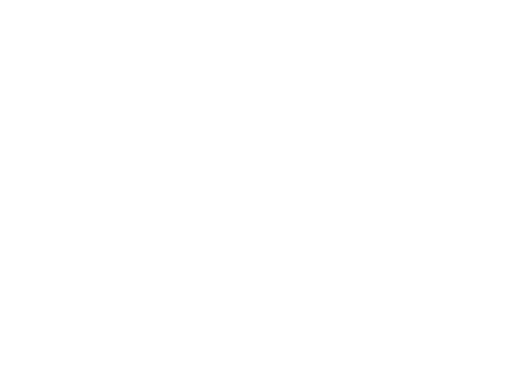

<IPython.core.display.Javascript object>


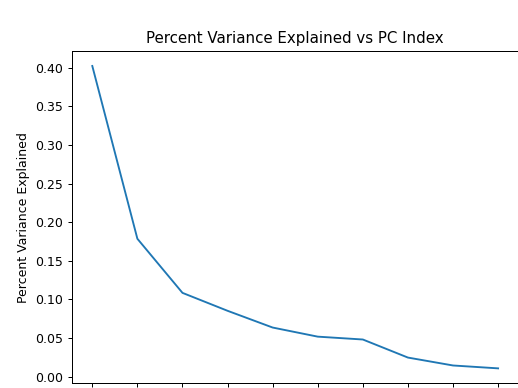

In [50]:
n_components_test=10
pca_data = dru.pca_analysis(
    X,
    n_components=n_components_test,
    plot_sqrt_eigvals=False,
    plot_perc_variance_explained=True
)

X_pca = pca_data["data_proj"]

# a) PCA

In [51]:
sys.path.append('/meshAfterParty/meshAfterParty/')
import datajoint_utils as du
import cell_type_utils as ctu

WARNING - 2022-05-04 23:55:28,468 - _default - No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


Using default Google credentials. There is no ~/.cloudvolume/secrets/google-secret.json set.


INFO - 2022-05-04 23:55:31,313 - settings - Setting enable_python_native_blobs to True
INFO - 2022-05-04 23:55:31,316 - settings - Setting stores to {'h01_skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/skeletons', 'stage': '/mnt/dj-stor01/microns/h01/skeletons'}, 'h01_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/meshes', 'stage': '/mnt/dj-stor01/microns/h01/meshes'}, 'h01_faces': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/faces', 'stage': '/mnt/dj-stor01/microns/h01/faces'}, 'h01_decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/decimated_meshes', 'stage': '/mnt/dj-stor01/microns/h01/decimated_meshes'}, 'h01_soma_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/soma_meshes', 'stage': '/mnt/dj-stor01/microns/h01/soma_meshes'}}
INFO - 2022-05-04 23:55:31,331 - connection - Connected celiib@at-database.ad.bcm.edu:3306


Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2022-05-04 23:55:32,496 - settings - Setting enable_python_native_blobs to True
WARNING - 2022-05-04 23:55:36,172 - utils - DataJointPlus version check failed.
INFO - 2022-05-04 23:55:38,489 - settings - Setting enable_python_native_blobs to True
ERROR - 2022-05-04 23:55:38,527 - compatibility - Could not add DataJointPlus to ImportMethod.
Traceback (most recent call last):
  File "/datajoint-plus/datajoint_plus/compatibility.py", line 41, in add_datajoint_plus
    obj.parse_hash_info_from_header()
  File "/datajoint-plus/datajoint_plus/base.py", line 354, in parse_hash_info_from_header
    if result[0] == attr:
IndexError: list index out of range
ERROR - 2022-05-04 23:55:38,599 - compatibility - Could not add DataJointPlus to Materialization.
Traceback (most recent call last):
  File "/datajoint-plus/datajoint_plus/compatibility.py", line 41, in add_datajoint_plus
    obj.parse_hash_info_from_header()
  File "/datajoint-plus/datajoint_plus/base.py", line 354, in parse_hash_info

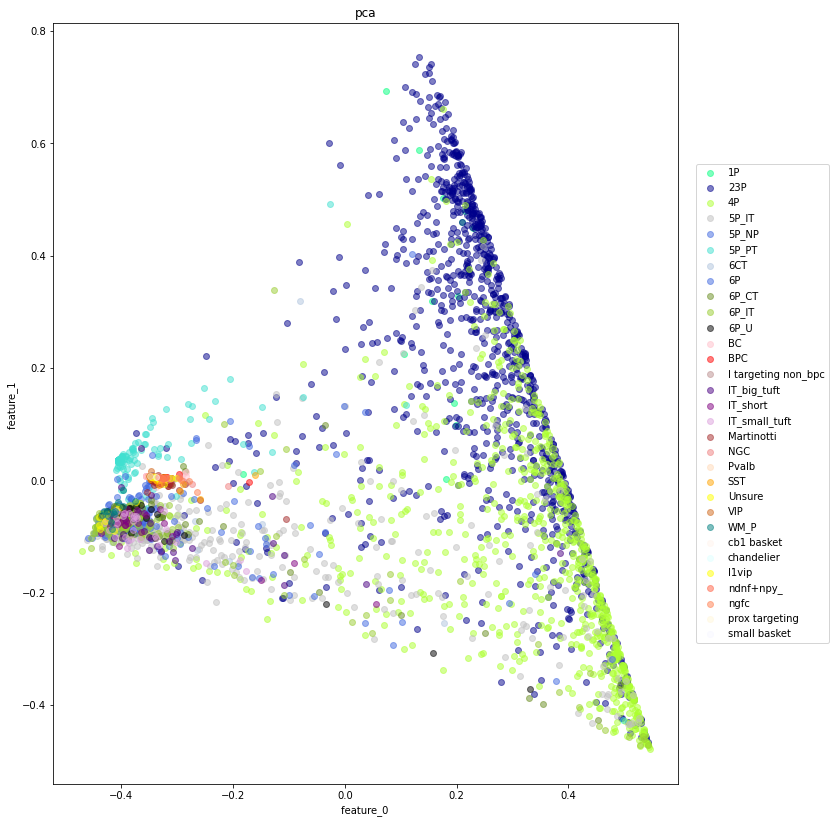

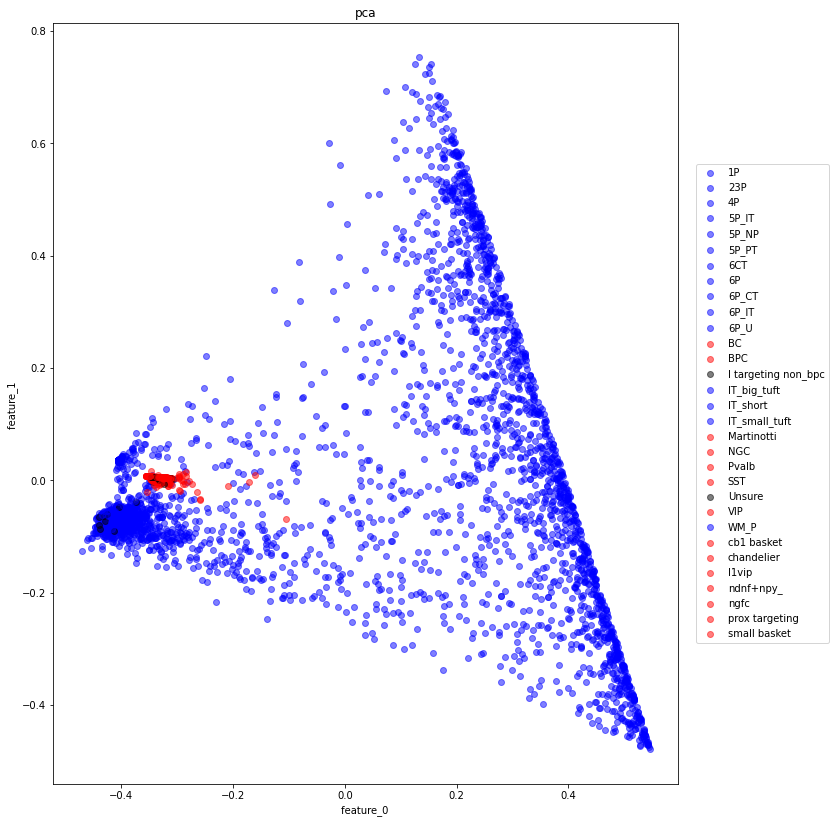

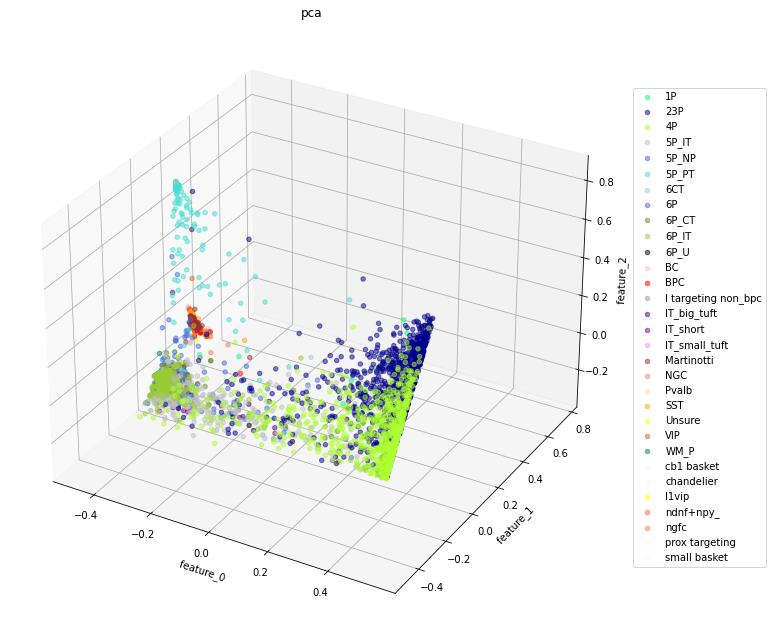

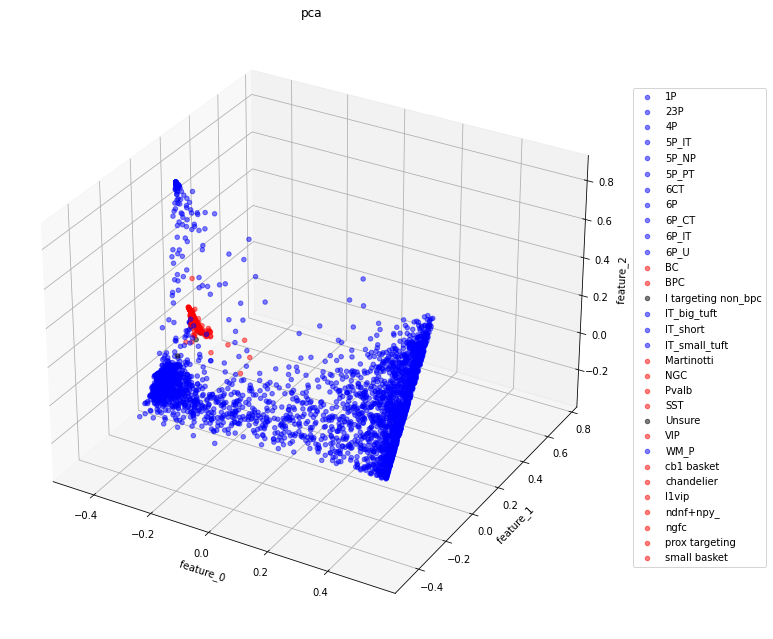

In [55]:
import dimensionality_reduction_ml as dru
import cell_type_utils as ctu
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "pca",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
)

# b) UMAP (0.5)

In [139]:
X_trans = dru.dimensionality_reduction_by_method(
        method="UMAP",
        X = X_input,
        n_components =2,
        min_dist = 0.5,
        )

In [140]:
method = "UMAP"

<AxesSubplot:title={'center':'UMAP'}, xlabel='feature_0 ', ylabel='feature_1 '>

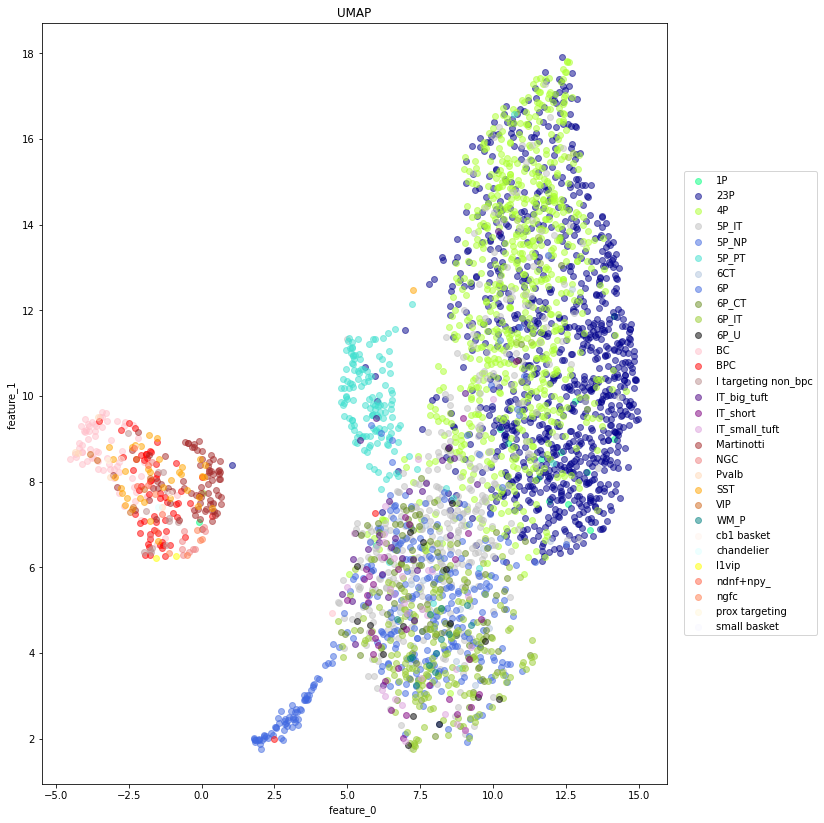

In [141]:
vml.plot_df_scatter_classification(
                X = X_trans,
                y = y_input,
                target_to_color = ctu.cell_type_fine_color_map,
                ndim = 2,
                title=method,
            )

<AxesSubplot:title={'center':'UMAP'}, xlabel='feature_0 ', ylabel='feature_1 '>

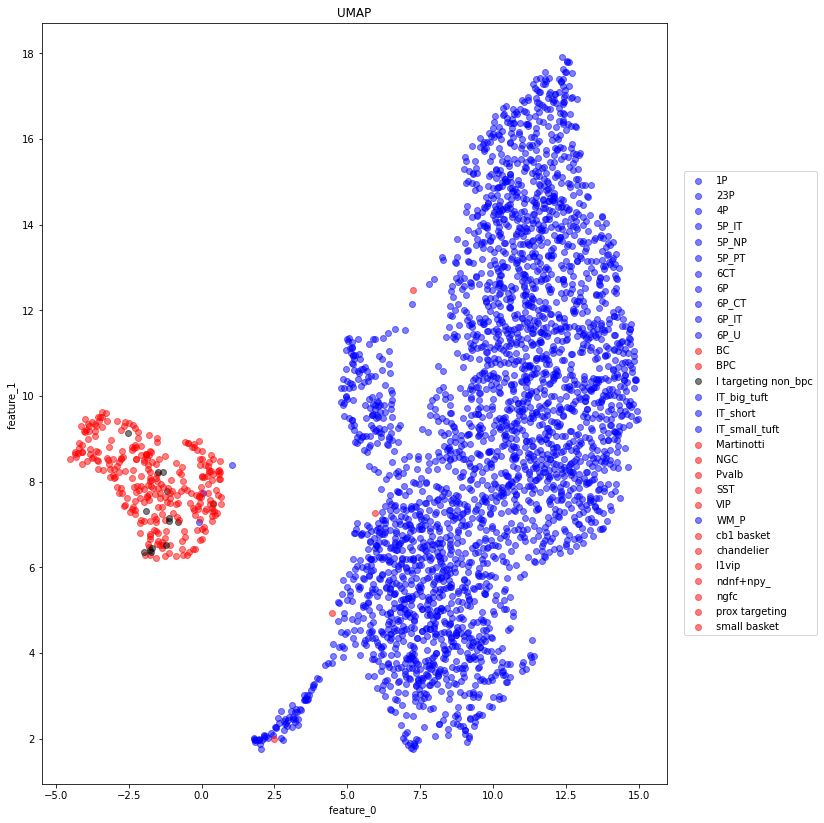

In [142]:
vml.plot_df_scatter_classification(
                X = X_trans,
                y = y_input,
                target_to_color = ctu.e_i_color_dict(),
                ndim = 2,
                title=method,
            )

<AxesSubplot:title={'center':'UMAP'}, xlabel='feature_0 ', ylabel='feature_1 '>

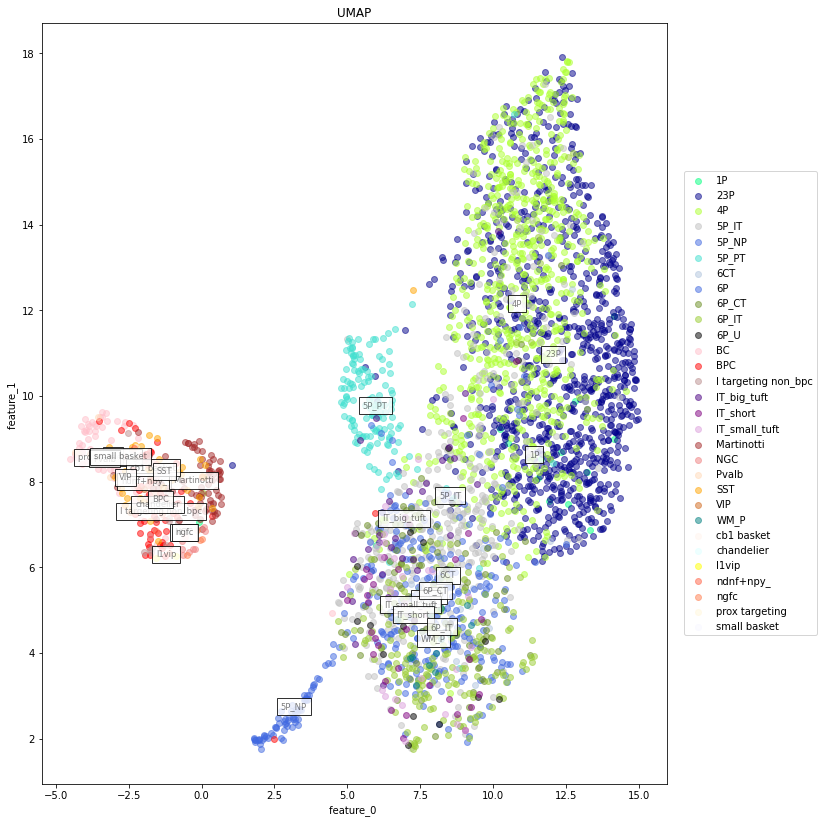

In [143]:
vml.plot_df_scatter_classification(
                X = X_trans,
                y = y_input,
                target_to_color = ctu.cell_type_fine_color_map,
                ndim = 2,
                title=method,
    use_labels_as_text_to_plot=True
            )

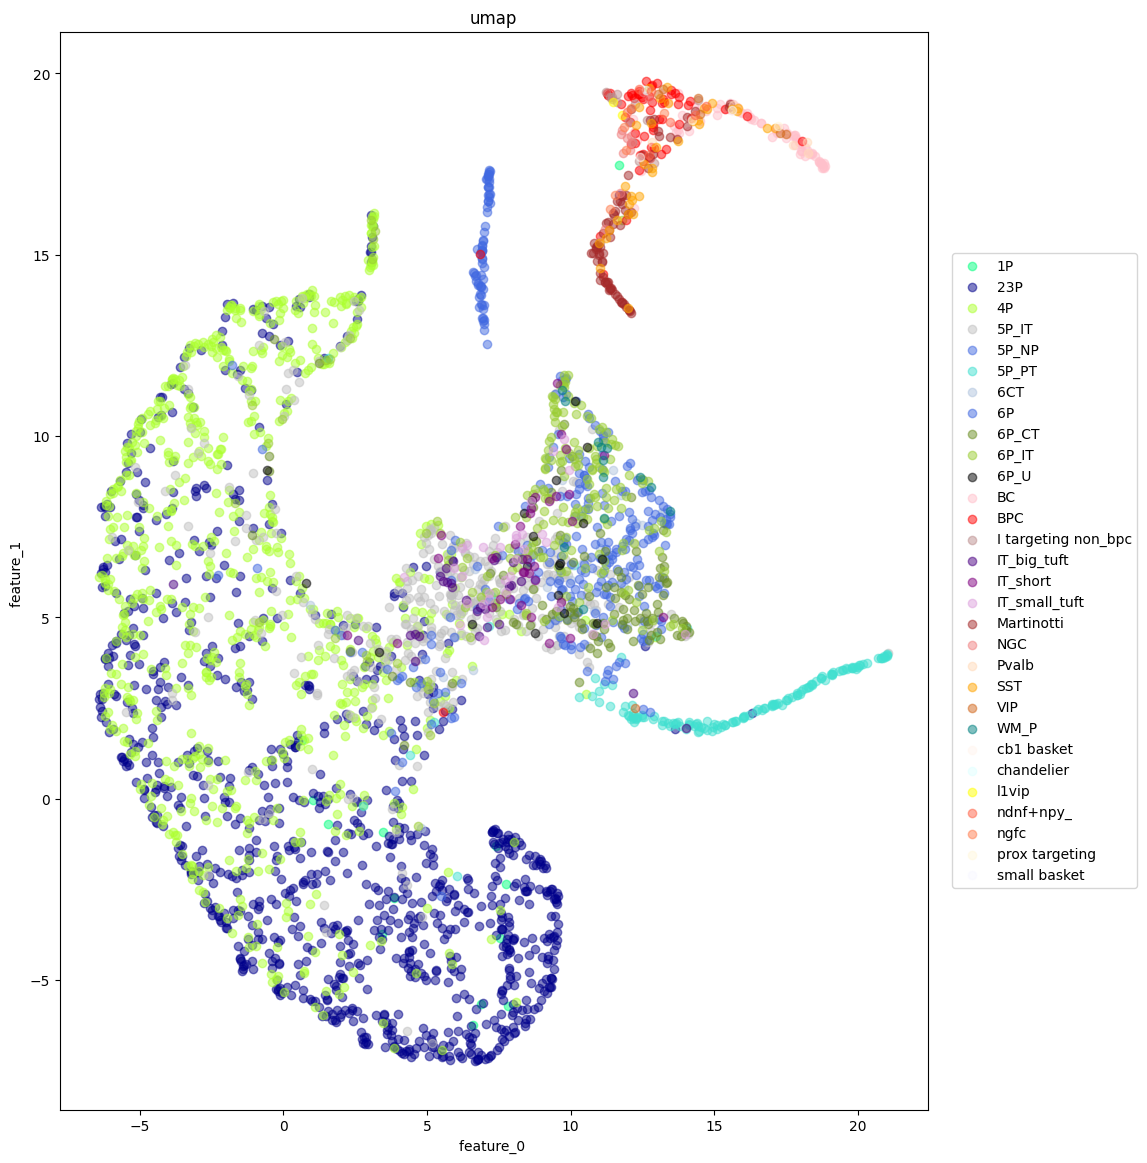

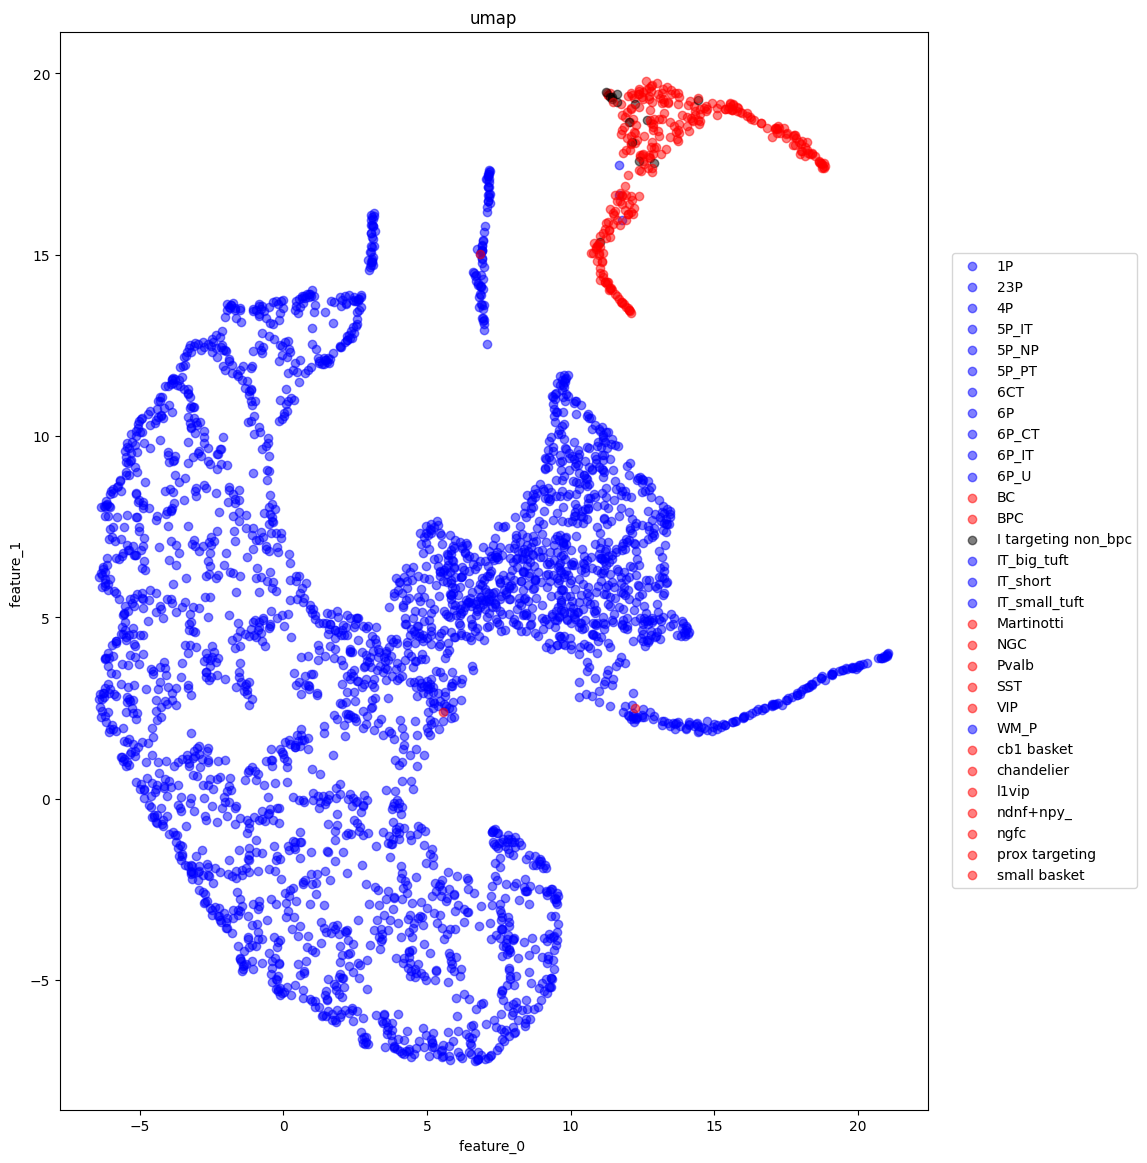

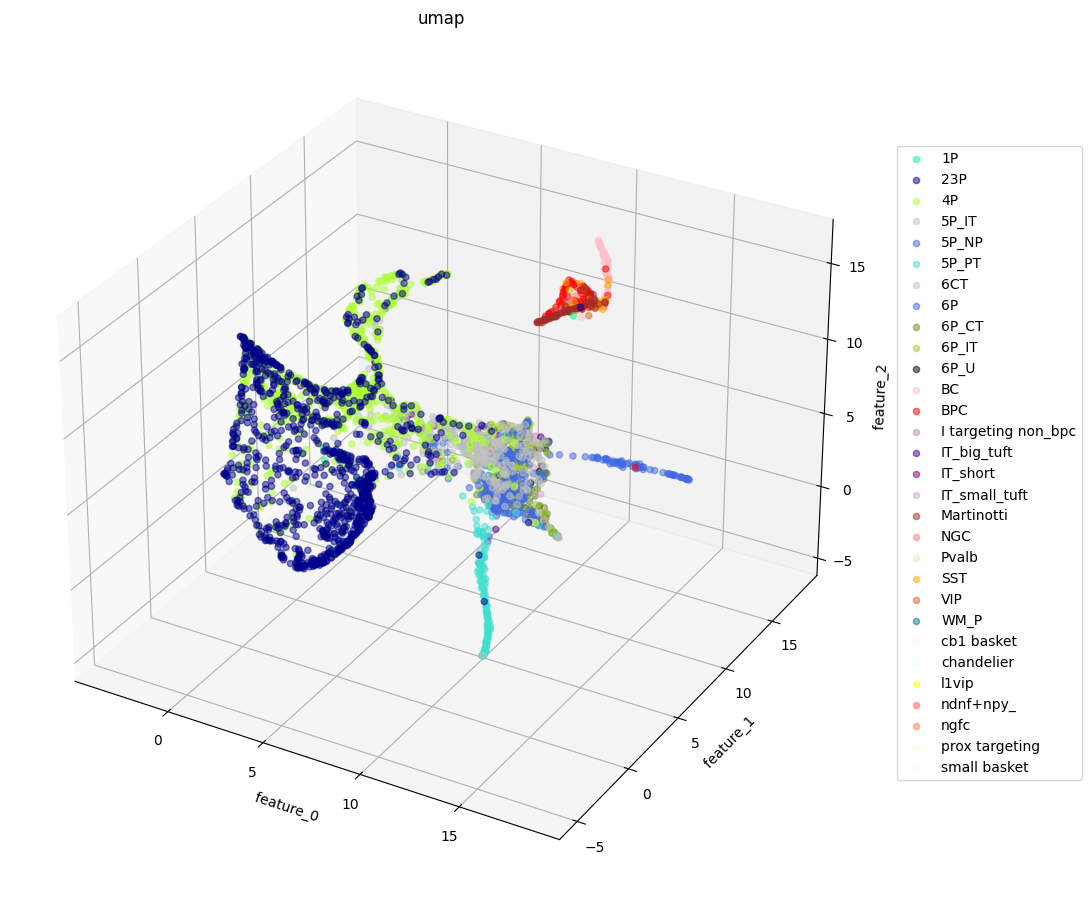

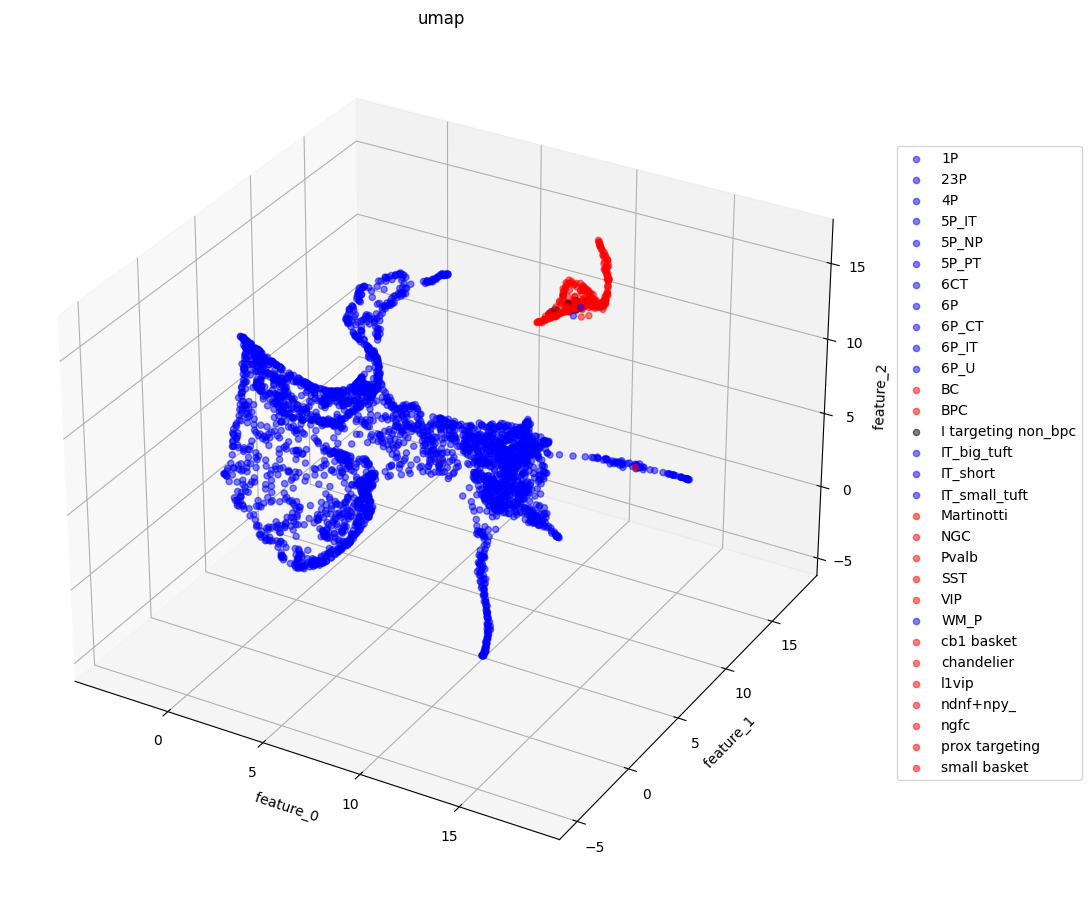

In [115]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "umap",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    min_dist = 0.5,
    #plot_kwargs=dict(use_labels_as_text_to_plot = True)
)

# b) UMAP (0.2)

In [57]:
sys.path.append("/meshAfterParty/meshAfterParty/")
import datajoint_utils as du
import cell_type_utils as ctu

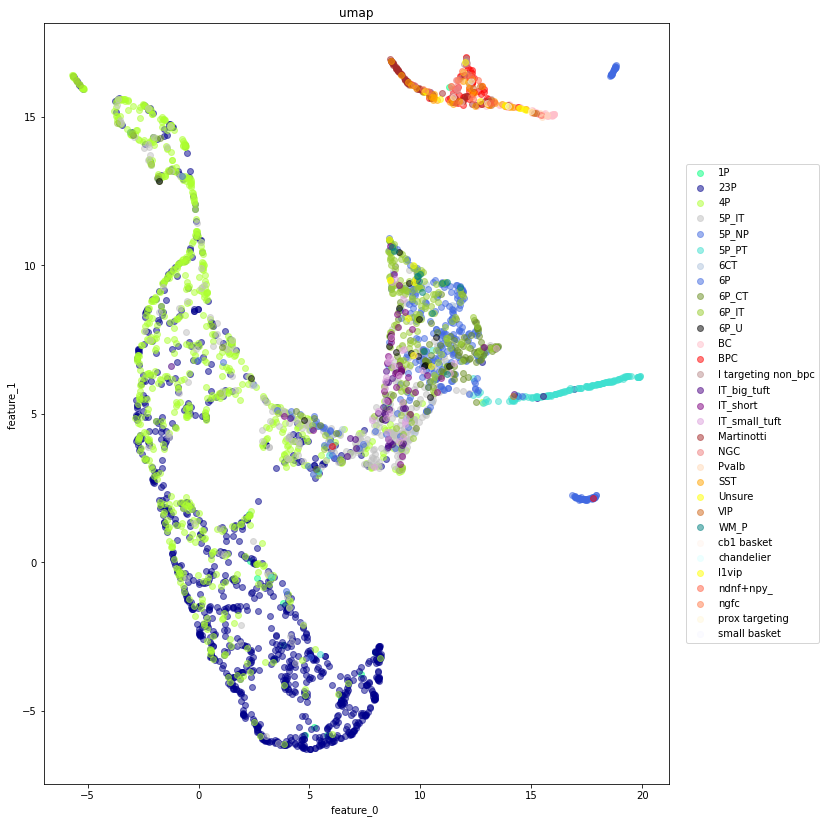

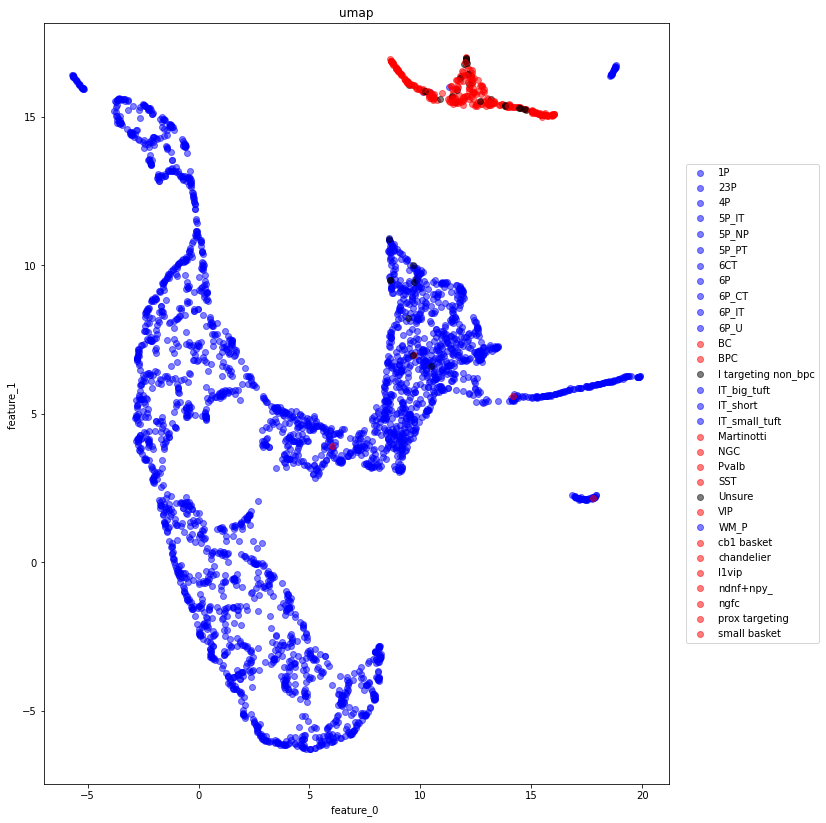

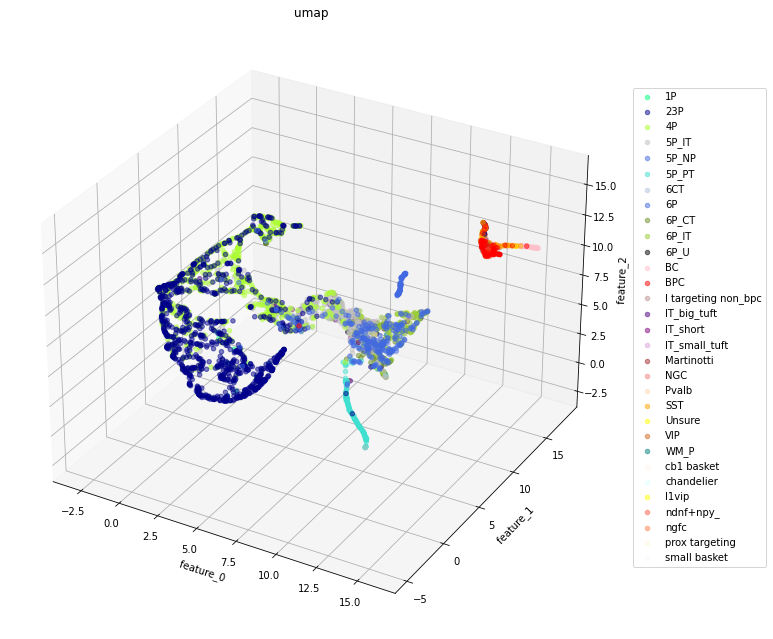

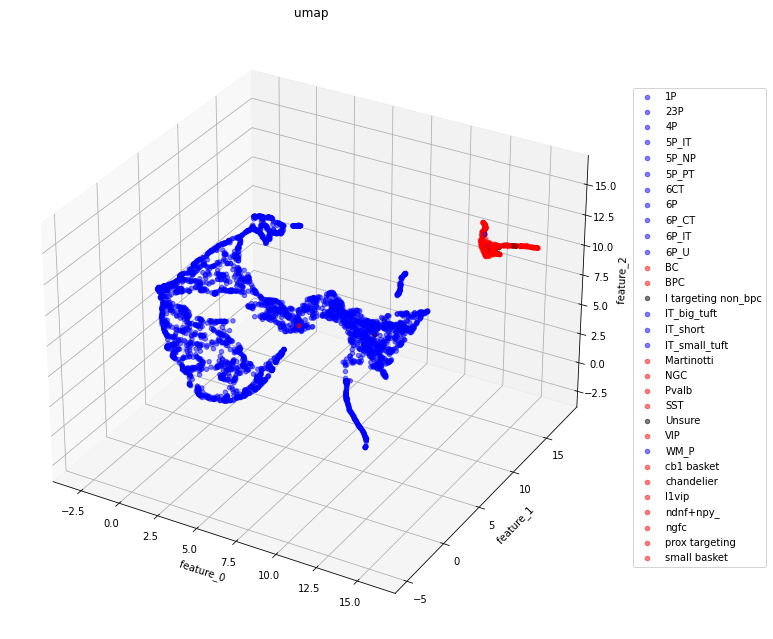

In [58]:
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "umap",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    min_dist = 0.2,
)

# tsne

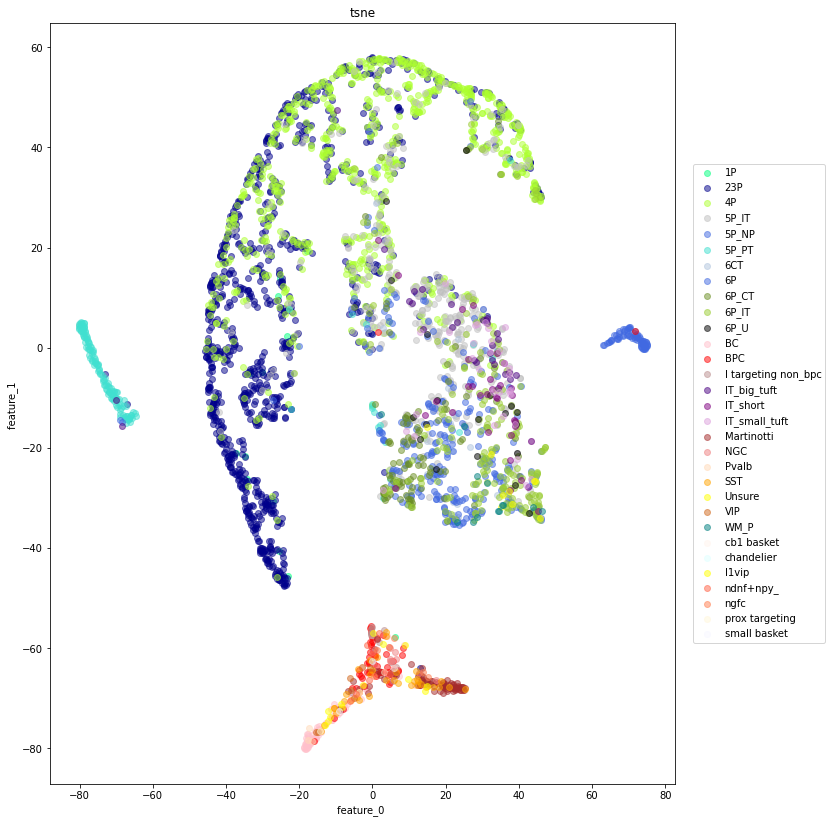

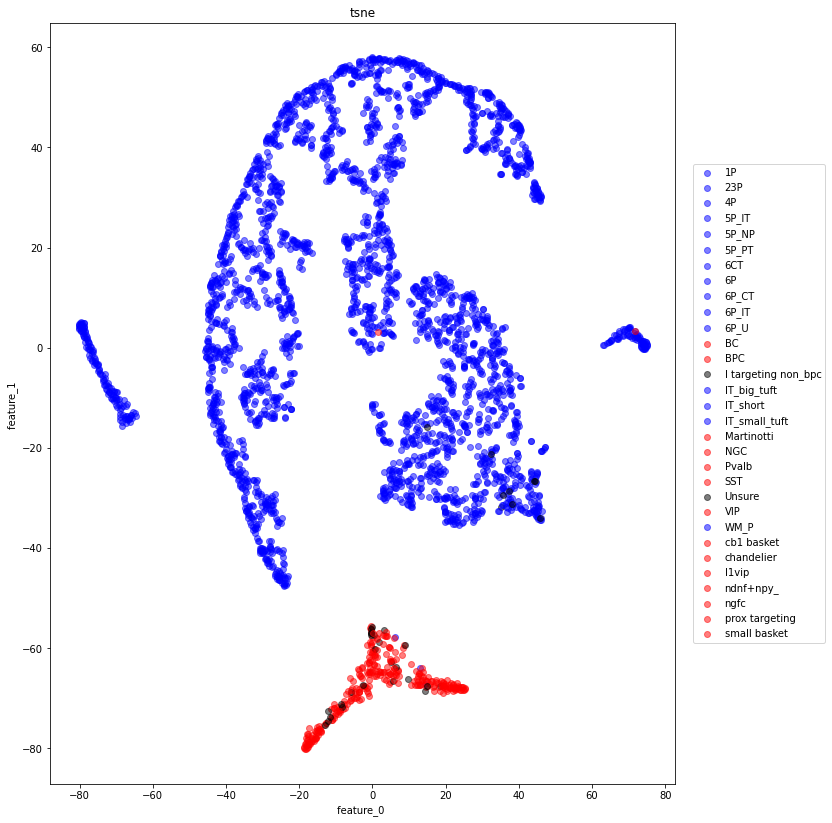

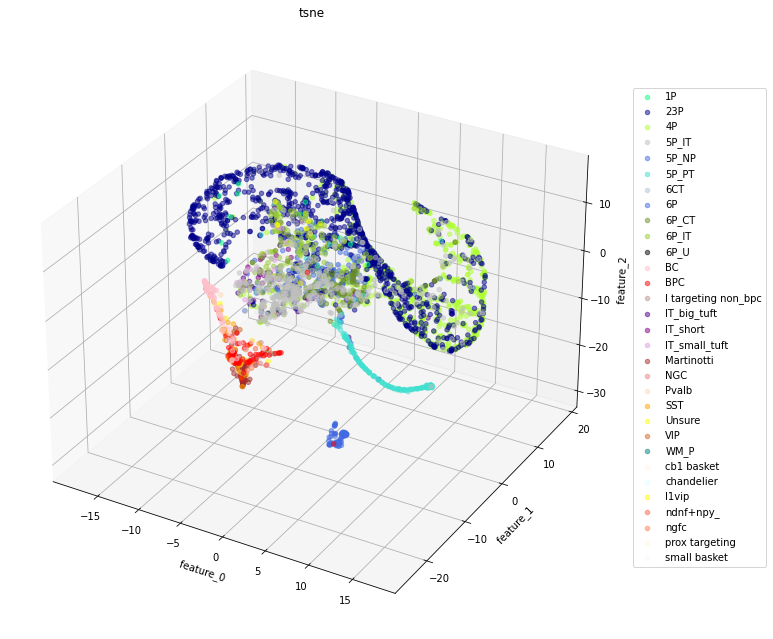

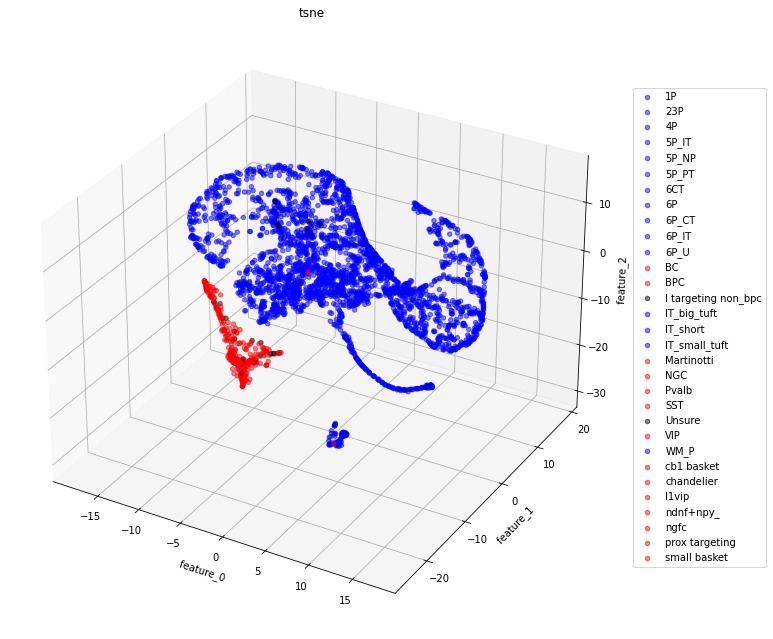

In [59]:
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "tsne",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    #min_dist = 0.2,
)

# Running a Classification and then a confusion matrix

In [63]:
embedding_df

0             1             2             3             4  \
0      9.361723e-06  4.455514e-02  9.353451e-03  1.413280e-03  1.338901e-03   
1      4.877127e-11  8.122378e-06  2.216633e-04  8.496497e-07  5.414684e-05   
2      9.795613e-34  7.884439e-24  8.875550e-22  6.446985e-31  1.039233e-22   
3      5.926092e-07  2.623787e-03  4.520399e-03  3.133778e-04  5.533628e-03   
4      4.391331e-06  2.542928e-03  1.649222e-01  6.866068e-01  3.187190e-02   
...             ...           ...           ...           ...           ...   
58943  6.295385e-06  1.918108e-03  4.736213e-02  3.801111e-02  2.201819e-01   
58944  1.656561e-05  1.602123e-02  5.548374e-01  9.070429e-02  1.506256e-01   
58945  2.673105e-06  4.707459e-03  6.946265e-01  1.883363e-01  8.664265e-02   
58946  2.035709e-04  1.159969e-02  2.314651e-02  3.670668e-02  1.440202e-02   
58947  3.220499e-06  4.678800e-02  6.876346e-01  7.397495e-02  4.733205e-02   

                  5             6             7             8             9  \
0      3.003129e-03  6.577132e-03  1.173289e-01  1.611165e-01  7.497672e-03   
1      4.222817e-10  9.992693e-01  1.083042e-05  3.016015e-04  1.320523e-04   
2      0.000000e+00  1.000000e+00  2.342094e-27  5.735907e-23  1.716826e-23   
3      4.585430e-05  4.832619e-02  1.329306e-01  6.222801e-01  1.284008e-02   
4      1.872686e-04  2.882888e-07  7.594885e-05  3.170583e-04  3.116010e-05   
...             ...           ...           ...           ...           ...   
58943  1.030872e-04  8.417304e-03  7.905874e-02  4.047858e-01  1.446478e-01   
58944  2.094715e-06  3.062932e-02  9.671056e-03  9.057651e-02  1.811820e-02   
58945  6.573809e-08  1.240723e-02  2.212043e-04  4.248714e-03  3.297371e-03   
58946  8.245949e-04  4.808962e-03  3.993338e-03  7.160765e-03  8.078413e-03   
58947  2.089334e-05  1.594035e-02  1.773029e-02  8.973239e-02  1.451272e-02   

       ...            23            24            25            26  \
0      ...  1.733039e-05  1.668411e-02  9.680733e-06  4.726157e-04   
1      ...  5.224869e-09  1.016821e-07  3.143233e-11  2.905064e-11   
2      ...  1.075777e-23  1.856095e-26  3.171036e-34  1.391625e-36   
3      ...  5.331170e-06  1.302088e-01  5.139901e-07  1.812650e-05   
4      ...  9.501731e-05  3.031886e-05  4.983229e-06  3.153075e-03   
...    ...           ...           ...           ...           ...   
58943  ...  4.983118e-06  7.781191e-04  5.243748e-06  2.027889e-05   
58944  ...  2.048208e-04  1.157119e-03  1.389594e-05  1.729739e-04   
58945  ...  1.186480e-04  5.066671e-06  2.307116e-06  2.495185e-05   
58946  ...  6.784136e-03  4.664020e-04  1.805688e-04  7.484454e-03   
58947  ...  1.553601e-05  2.736358e-04  2.969625e-06  3.216258e-05   

                 27            28            29            30            31  \
0      4.340166e-02  2.061392e-03  3.244962e-02  1.254825e-05  2.893451e-05   
1      2.129500e-08  6.296084e-10  7.047968e-11  2.571166e-09  1.875575e-11   
2      3.340240e-31  4.208515e-32  0.000000e+00  3.216013e-26  3.703076e-34   
3      3.012051e-04  2.861340e-05  1.120558e-04  8.713089e-06  1.627218e-06   
4      6.268207e-06  2.807410e-04  1.185103e-02  1.803282e-06  4.252774e-05   
...             ...           ...           ...           ...           ...   
58943  1.245276e-04  1.158110e-05  3.139091e-05  1.216668e-05  4.347348e-06   
58944  1.491179e-04  1.884722e-05  9.610566e-05  4.016640e-05  1.334424e-05   
58945  1.042845e-05  3.123350e-06  9.244944e-06  3.814471e-06  1.651865e-06   
58946  6.309766e-03  4.939875e-02  2.173830e-02  5.226699e-04  3.203730e-03   
58947  5.376348e-04  1.244990e-05  2.010865e-04  3.078612e-06  1.292570e-06   

       cell_type  
0        Unknown  
1        Unknown  
2        Unknown  
3        Unknown  
4        Unknown  
...          ...  
58943    Unknown  
58944    Unknown  
58945    Unknown  
58946    Unknown  
58947    Unknown  

[58948 rows x 33 columns]

In [68]:
import pandas_ml as pdml
df_labeled = embedding_df.query("(cell_type!='Unknown') and (cell_type != 'Unsure')")
X,y = pdml.X_y(df_labeled,"cell_type")
class_label_idx = np.argmax(X.to_numpy(),axis=1)
decoder = {v:k for k,v in cell_type_map.items()}
df_labeled["cell_type_predicted"] = [decoder[k] for k in class_label_idx]
df_labeled

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0             1             2             3         4  \
61     6.371334e-09  9.457405e-05  1.296945e-01  8.651648e-01  0.004788   
93     7.391989e-08  7.598033e-04  4.536186e-01  5.167737e-01  0.027482   
116    3.579105e-05  5.299749e-03  9.549609e-02  1.589832e-01  0.201974   
151    1.055072e-05  7.099598e-06  1.945247e-04  1.277354e-03  0.237146   
159    3.029876e-05  3.672780e-02  6.241859e-01  2.447461e-01  0.055843   
...             ...           ...           ...           ...       ...   
58907  4.067735e-08  2.763870e-04  2.021584e-01  7.863317e-01  0.010448   
58911  3.443543e-12  7.883950e-06  1.450271e-01  8.537524e-01  0.001205   
58928  5.659891e-10  2.368788e-12  2.613199e-11  1.175609e-08  0.000533   
58937  4.223162e-05  8.117440e-05  1.952847e-03  1.130066e-02  0.323099   
58940  1.104900e-04  7.221145e-05  7.508130e-05  3.777466e-04  0.000408   

                  5             6             7             8             9  \
61     2.044236e-08  4.145250e-09  3.415646e-06  2.649173e-05  1.074241e-05   
93     7.763037e-08  6.430511e-07  4.278190e-05  3.221914e-04  3.785848e-05   
116    1.189274e-04  9.193708e-04  7.597905e-02  2.652536e-01  7.990096e-02   
151    1.830674e-04  2.253154e-03  1.948616e-02  1.650115e-01  1.030735e-01   
159    2.151692e-05  1.365645e-03  3.339710e-03  1.236014e-02  2.836777e-03   
...             ...           ...           ...           ...           ...   
58907  2.361079e-07  7.489333e-08  4.704134e-06  2.568616e-05  8.903682e-06   
58911  7.005399e-12  5.393526e-11  1.775931e-08  3.267551e-07  9.782531e-09   
58928  9.875242e-01  2.531697e-08  1.008103e-04  1.903286e-04  3.836037e-05   
58937  2.473055e-04  1.905888e-03  2.729741e-02  1.462604e-01  1.057899e-01   
58940  3.558043e-04  5.943253e-04  1.880153e-04  2.463666e-04  2.309979e-03   

       ...            25            26            27            28  \
61     ...  6.530318e-09  5.235232e-07  4.378685e-08  4.591227e-09   
93     ...  6.616569e-08  6.398344e-06  2.667228e-07  4.739163e-08   
116    ...  3.342723e-05  3.008701e-04  5.235148e-04  5.894681e-05   
151    ...  9.530514e-06  1.340110e-05  1.040954e-05  3.083102e-05   
159    ...  2.907543e-05  6.148479e-04  4.683080e-04  8.333879e-05   
...    ...           ...           ...           ...           ...   
58907  ...  3.652566e-08  1.430563e-06  9.106468e-08  2.452553e-08   
58911  ...  2.980968e-12  1.177276e-08  1.363016e-11  3.779223e-12   
58928  ...  3.735854e-10  1.809075e-10  7.009802e-11  1.902378e-07   
58937  ...  3.946836e-05  6.719232e-05  3.990029e-05  5.675920e-05   
58940  ...  9.408857e-05  1.224237e-03  7.703752e-04  1.166034e-01   

                 29            30            31  cell_type  predicted_label  \
61     2.216442e-06  1.790530e-10  1.256599e-09         4P               4P   
93     1.019066e-05  9.277198e-09  2.433355e-08        23P               4P   
116    4.567268e-04  3.484950e-05  3.331012e-05      5P_IT               6P   
151    1.383170e-06  2.033412e-04  6.868385e-05   IT_short            6P_IT   
159    1.341127e-03  1.722439e-05  2.462921e-05        23P              23P   
...             ...           ...           ...        ...              ...   
58907  5.791704e-06  1.232212e-09  6.608705e-09         4P               4P   
58911  3.231351e-08  3.107142e-14  3.847700e-13         4P               4P   
58928  1.543956e-10  7.027069e-08  5.643695e-08      5P_NP            5P_NP   
58937  1.278066e-05  2.533254e-04  1.204834e-04         6P            5P_IT   
58940  1.168017e-03  2.230983e-03  1.181555e-02        BPC              BPC   

       cell_type_predicted  
61                      4P  
93                      4P  
116                     6P  
151                  6P_IT  
159                    23P  
...                    ...  
58907                   4P  
58911                   4P  
58928                5P_NP  
58937                5P_IT  
58940                  BPC  

[3318 rows x 35 columns]

In [79]:
accuracy = len(df_labeled.query("cell_type == cell_type_predicted"))/len(df_labeled)
accuracy

0.5946353224834238

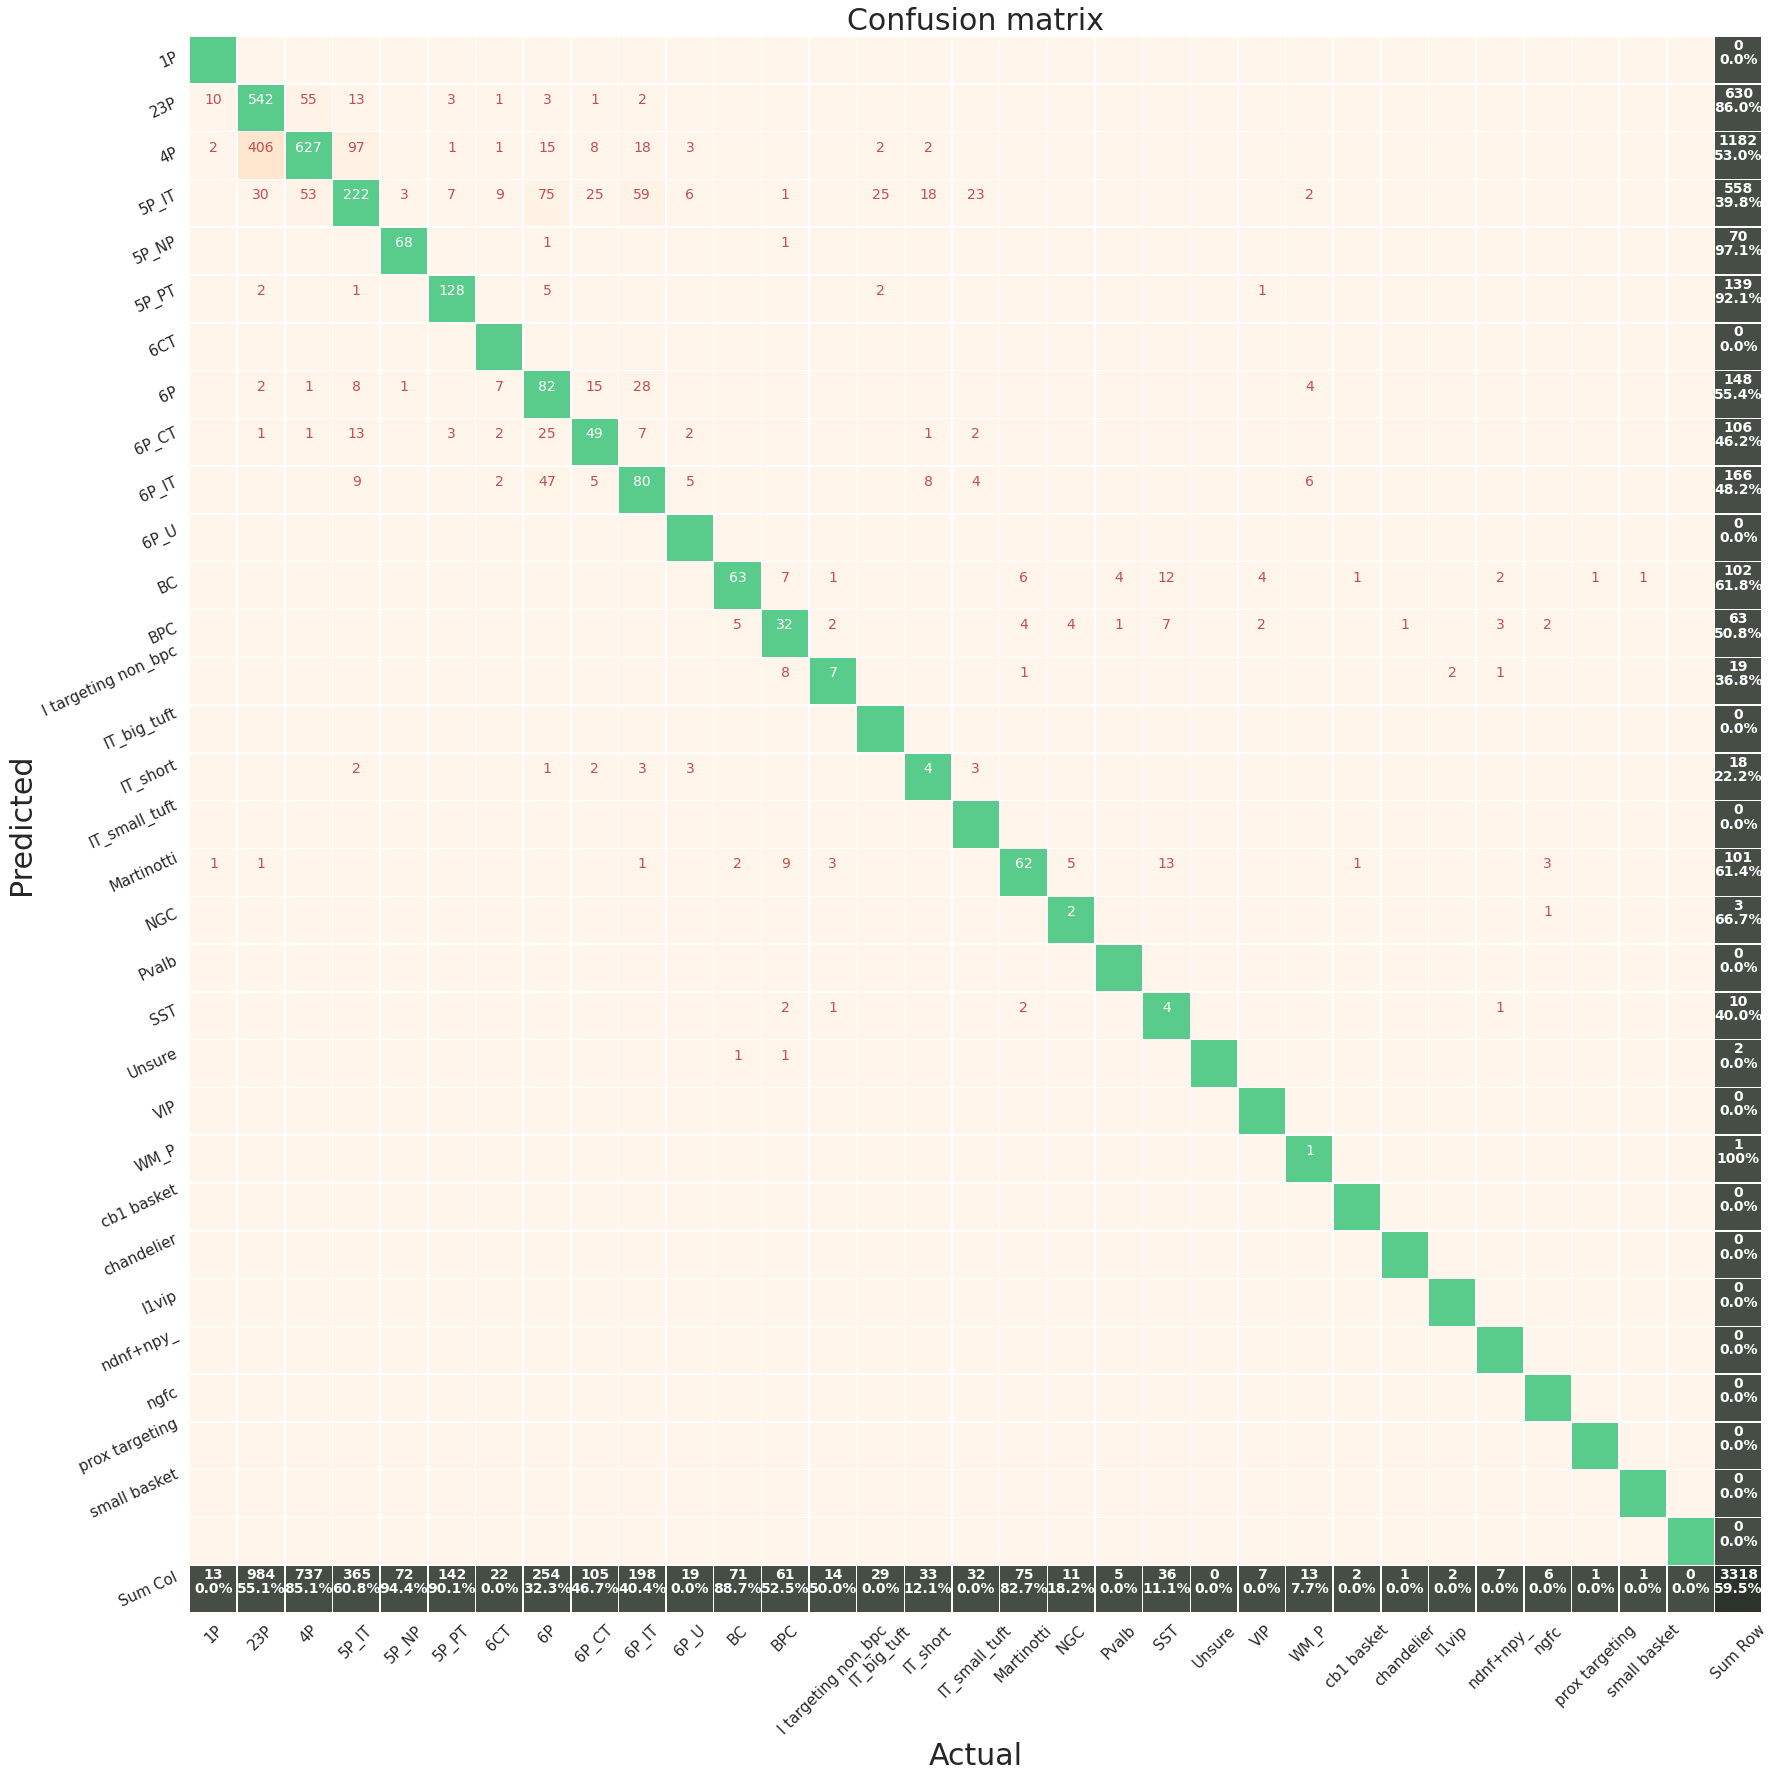

In [113]:
import statistics_visualizations as sviz
sviz.plot_pretty_confusion_matrix(
    y_true = df_labeled["cell_type"],
    y_pred = df_labeled["cell_type_predicted"],
    labels = list(cell_type_map.keys()),
    figsize=(25,25),
    cell_fontsize = 14,
    ticklabel_fontsize=15)

# Confusion matrix of EI

In [101]:
df_labeled["e_i_label"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type"].to_numpy()]
df_labeled["e_i_predicted"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type_predicted"].to_numpy()]
df_labeled

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0             1             2             3         4  \
61     6.371334e-09  9.457405e-05  1.296945e-01  8.651648e-01  0.004788   
93     7.391989e-08  7.598033e-04  4.536186e-01  5.167737e-01  0.027482   
116    3.579105e-05  5.299749e-03  9.549609e-02  1.589832e-01  0.201974   
151    1.055072e-05  7.099598e-06  1.945247e-04  1.277354e-03  0.237146   
159    3.029876e-05  3.672780e-02  6.241859e-01  2.447461e-01  0.055843   
...             ...           ...           ...           ...       ...   
58907  4.067735e-08  2.763870e-04  2.021584e-01  7.863317e-01  0.010448   
58911  3.443543e-12  7.883950e-06  1.450271e-01  8.537524e-01  0.001205   
58928  5.659891e-10  2.368788e-12  2.613199e-11  1.175609e-08  0.000533   
58937  4.223162e-05  8.117440e-05  1.952847e-03  1.130066e-02  0.323099   
58940  1.104900e-04  7.221145e-05  7.508130e-05  3.777466e-04  0.000408   

                  5             6             7             8             9  \
61     2.044236e-08  4.145250e-09  3.415646e-06  2.649173e-05  1.074241e-05   
93     7.763037e-08  6.430511e-07  4.278190e-05  3.221914e-04  3.785848e-05   
116    1.189274e-04  9.193708e-04  7.597905e-02  2.652536e-01  7.990096e-02   
151    1.830674e-04  2.253154e-03  1.948616e-02  1.650115e-01  1.030735e-01   
159    2.151692e-05  1.365645e-03  3.339710e-03  1.236014e-02  2.836777e-03   
...             ...           ...           ...           ...           ...   
58907  2.361079e-07  7.489333e-08  4.704134e-06  2.568616e-05  8.903682e-06   
58911  7.005399e-12  5.393526e-11  1.775931e-08  3.267551e-07  9.782531e-09   
58928  9.875242e-01  2.531697e-08  1.008103e-04  1.903286e-04  3.836037e-05   
58937  2.473055e-04  1.905888e-03  2.729741e-02  1.462604e-01  1.057899e-01   
58940  3.558043e-04  5.943253e-04  1.880153e-04  2.463666e-04  2.309979e-03   

       ...            27            28            29            30  \
61     ...  4.378685e-08  4.591227e-09  2.216442e-06  1.790530e-10   
93     ...  2.667228e-07  4.739163e-08  1.019066e-05  9.277198e-09   
116    ...  5.235148e-04  5.894681e-05  4.567268e-04  3.484950e-05   
151    ...  1.040954e-05  3.083102e-05  1.383170e-06  2.033412e-04   
159    ...  4.683080e-04  8.333879e-05  1.341127e-03  1.722439e-05   
...    ...           ...           ...           ...           ...   
58907  ...  9.106468e-08  2.452553e-08  5.791704e-06  1.232212e-09   
58911  ...  1.363016e-11  3.779223e-12  3.231351e-08  3.107142e-14   
58928  ...  7.009802e-11  1.902378e-07  1.543956e-10  7.027069e-08   
58937  ...  3.990029e-05  5.675920e-05  1.278066e-05  2.533254e-04   
58940  ...  7.703752e-04  1.166034e-01  1.168017e-03  2.230983e-03   

                 31  cell_type  predicted_label  cell_type_predicted  \
61     1.256599e-09         4P               4P                   4P   
93     2.433355e-08        23P               4P                   4P   
116    3.331012e-05      5P_IT               6P                   6P   
151    6.868385e-05   IT_short            6P_IT                6P_IT   
159    2.462921e-05        23P              23P                  23P   
...             ...        ...              ...                  ...   
58907  6.608705e-09         4P               4P                   4P   
58911  3.847700e-13         4P               4P                   4P   
58928  5.643695e-08      5P_NP            5P_NP                5P_NP   
58937  1.204834e-04         6P            5P_IT                5P_IT   
58940  1.181555e-02        BPC              BPC                  BPC   

        e_i_label  e_i_predicted  
61     excitatory     excitatory  
93     excitatory     excitatory  
116    excitatory     excitatory  
151    excitatory     excitatory  
159    excitatory     excitatory  
...           ...            ...  
58907  excitatory     excitatory  
58911  excitatory     excitatory  
58928  excitatory     excitatory  
58937  excitatory     excitatory  
58940  inhibitory     inhibitory  

[3318 rows x 37 columns]

In [108]:
df_labeled_filt = df_labeled.query("e_i_label != 'unknown'")

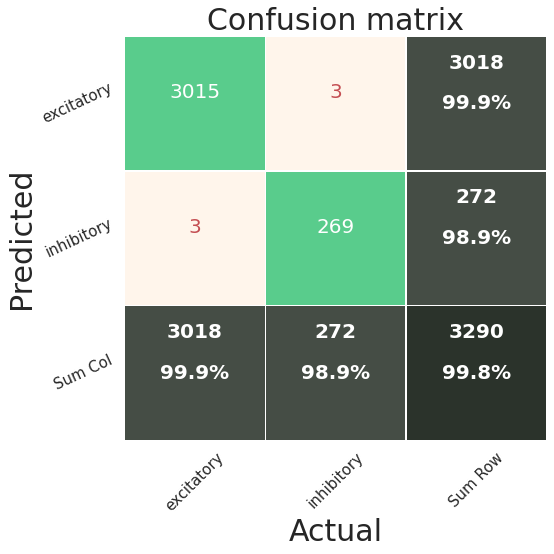

In [111]:
import statistics_visualizations as sviz
sviz.plot_pretty_confusion_matrix(
    y_true = df_labeled["e_i_label"],
    y_pred = df_labeled["e_i_predicted"],
    labels = list(df_labeled_filt["e_i_label"].unique()),
    figsize=(8,8),
    #cell_fontsize = 15,
    #ticklabel_fontsize=15
)

# Computing the Test Accuracy

In [145]:
all_data_loader = data_loader_mod(test_dataset, batch_size=batch_size,shuffle = False)
all_data_loader

model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    data = data.to(device)
    if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(data)

    out_array = out.detach().cpu().numpy()
    out_labels = data.y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

import pandas_ml as pdml
df_labeled = embedding_df.query("(cell_type!='Unknown') and (cell_type != 'Unsure')")
X,y = pdml.X_y(df_labeled,"cell_type")
class_label_idx = np.argmax(X.to_numpy(),axis=1)
decoder = {v:k for k,v in cell_type_map.items()}
df_labeled["cell_type_predicted"] = [decoder[k] for k in class_label_idx]
df_labeled["e_i_label"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type"].to_numpy()]
df_labeled["e_i_predicted"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type_predicted"].to_numpy()]

accuracy = len(df_labeled.query("cell_type == cell_type_predicted"))/len(df_labeled)
print(f"cell_type_fine test accuracy: {accuracy}")
accuracy = len(df_labeled.query("e_i_label == e_i_predicted"))/len(df_labeled)
print(f"e_i_label test accuracy: {accuracy}")

  0%|          | 0/11 [00:00<?, ?it/s]

In [152]:
all_data_loader = data_loader_mod(val_dataset, batch_size=batch_size,shuffle = False)
all_data_loader

model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    data = data.to(device)
    if model_name == "DiffPoolGCN":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(data)

    out_array = out.detach().cpu().numpy()
    out_labels = data.y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

import pandas_ml as pdml
df_labeled = embedding_df.query("(cell_type!='Unknown') and (cell_type != 'Unsure')")
X,y = pdml.X_y(df_labeled,"cell_type")
class_label_idx = np.argmax(X.to_numpy(),axis=1)
decoder = {v:k for k,v in cell_type_map.items()}
df_labeled["cell_type_predicted"] = [decoder[k] for k in class_label_idx]
df_labeled["e_i_label"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type"].to_numpy()]
df_labeled["e_i_predicted"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type_predicted"].to_numpy()]

accuracy = len(df_labeled.query("cell_type == cell_type_predicted"))/len(df_labeled)
print(f"cell_type_fine test accuracy: {accuracy}")
accuracy = len(df_labeled.query("e_i_label == e_i_predicted"))/len(df_labeled)
print(f"e_i_label test accuracy: {accuracy}")

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cell_type_fine test accuracy: 0.5912518853695324
e_i_label test accuracy: 0.9909502262443439


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
